Introduction

outline

Imports

In [59]:
# Uninstall both packages
!pip uninstall -y numpy

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [60]:
# Install numpy first with a version that works with Python 3.11
!pip install numpy==1.24.3

# Then install Cython with a compatible version
!pip install Cython==0.29.36

# Finally install pmdarima
!pip install pmdarima==2.0.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.



  Obtaining dependency information for numpy==1.24.3 from https://files.pythonhosted.org/packages/f0/e8/1ea9adebdccaadfc208c7517e09f5145ed5a73069779ff436393085d47a2/numpy-1.24.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.8 MB 165.2 kB/s eta 0:01:30
   ---------------------------------------- 0.0/14.8 MB 163.8 kB/s eta 0:01:31
   ---------------------------------------- 0.0/14.8 MB 219.4 kB/s eta 0:01:08
   ---------------------------------------- 0.1/14.8 MB 252.2 kB/s eta 0:00:59
   ---------------------------------------- 0.1/14.8 MB 437.6 kB/s eta 0:00:34
   ---------------------------------------- 0.1/14.8 MB 450.6 kB/s eta 0:00:33
   ---------------------------------------- 0.1/14.8 MB 450.6 kB/s eta 0:00:33
   --------------------

In [1]:
import pandas as pd
import glob
import os
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pmdarima as pm
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalMaxPooling1D # Added GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential # Sequential might be used if Autoencoder stage 2 uses it
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GRU, LSTM, # LSTM for Autoencoder
    Dense, Dropout, Concatenate, Flatten, GlobalAveragePooling1D,
    Activation, Permute, Multiply, Lambda, # For Simple Attention (if used)
    RepeatVector, TimeDistributed # For Autoencoder
)
import tensorflow.keras.backend as K # For Lambda layer in Simple Attention
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler # Or your preferred scaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

Uploading the datasets

In [3]:
df_overall = pd.read_csv('overall_daily_oee.csv', parse_dates=["Date"])
df_overall.head()

,Date,Availability,Performance,Quality,OEE
0,2023-01-02,1.0,1.126069,1.0,1.126069
1,2023-01-03,1.0,1.051082,1.0,1.051082
2,2023-01-04,1.0,1.127245,1.0,1.127245
3,2023-01-05,1.0,1.240277,1.0,1.240277
4,2023-01-06,1.0,1.154885,1.0,1.154885


In [4]:
df_overall.dtypes

Date            datetime64[ns]
Availability           float64
Performance            float64
Quality                float64
OEE                    float64
dtype: object

Read Per-Line Daily OEE Reports

In [5]:
line_report_pattern = "daily_oee_report_*.csv"
line_report_files = glob.glob(line_report_pattern)

per_line_dataframes = {}

if not line_report_files:
    print(f"\nNo per-line report files found matching the pattern: '{line_report_pattern}'")
    print("Please ensure files like 'daily_oee_report_Line A.csv' exist in the working directory.")
else:
    print(f"\nFound {len(line_report_files)} per-line report files:")
    for filepath in line_report_files:
        # Extract production line name from filename
        # e.g., "daily_oee_report_Line A.csv" -> "Line A"
        filename = os.path.basename(filepath)

        # A common way to extract the part between prefix and suffix:
        prefix = "daily_oee_report_"
        suffix = ".csv"
        if filename.startswith(prefix) and filename.endswith(suffix):
            production_line_name = filename[len(prefix):-len(suffix)]
        else:
            print(f"Warning: Filename '{filename}' doesn't strictly match expected pattern. Using fallback key.")
            production_line_name = os.path.splitext(filename)[0] # e.g., "daily_oee_report_Line A"

        # Read the CSV, ensuring the 'Date' column is parsed as datetime objects
        df_line = pd.read_csv(filepath, parse_dates=["Date"])
        per_line_dataframes[production_line_name] = df_line

        print(f"\nSuccessfully read: {filepath} (for Production Line: '{production_line_name}')")
        print(f"First 5 rows for '{production_line_name}' (df stored in per_line_dataframes['{production_line_name}']):")
        display(df_line.head())
        print(f"\nData types for '{production_line_name}':")
        print(df_line.dtypes)
        print("-" * 30)


Found 5 per-line report files:

Successfully read: daily_oee_report_LINE-01.csv (for Production Line: 'LINE-01')
First 5 rows for 'LINE-01' (df stored in per_line_dataframes['LINE-01']):


,PRODUCTION_LINE,Date,Planned_Production_Time_Seconds,Actual_Run_Time_Seconds,Total_Actual_Output,Ideal_Cycle_Time_Seconds,Availability,Performance,Quality,OEE
0,LINE-01,2023-01-02,14520.0,14520.0,1177,11.0,1.0,0.891667,1.0,0.891667
1,LINE-01,2023-01-03,24780.0,24780.0,1976,11.0,1.0,0.877159,1.0,0.877159
2,LINE-01,2023-01-04,24420.0,24420.0,1977,11.0,1.0,0.890541,1.0,0.890541
3,LINE-01,2023-01-05,24300.0,24300.0,1976,11.0,1.0,0.894486,1.0,0.894486
4,LINE-01,2023-01-06,18240.0,18240.0,1534,11.0,1.0,0.925110,1.0,0.925110



Data types for 'LINE-01':
PRODUCTION_LINE                            object
Date                               datetime64[ns]
Planned_Production_Time_Seconds           float64
Actual_Run_Time_Seconds                   float64
Total_Actual_Output                         int64
Ideal_Cycle_Time_Seconds                  float64
Availability                              float64
Performance                               float64
Quality                                   float64
OEE                                       float64
dtype: object
------------------------------

Successfully read: daily_oee_report_LINE-02.csv (for Production Line: 'LINE-02')
First 5 rows for 'LINE-02' (df stored in per_line_dataframes['LINE-02']):


,PRODUCTION_LINE,Date,Planned_Production_Time_Seconds,Actual_Run_Time_Seconds,Total_Actual_Output,Ideal_Cycle_Time_Seconds,Availability,Performance,Quality,OEE
0,LINE-02,2023-01-02,0.0,0.0,1179,11.0,0.0,0.0,1.0,0.0
1,LINE-02,2023-01-03,0.0,0.0,1975,11.0,0.0,0.0,1.0,0.0
2,LINE-02,2023-01-04,0.0,0.0,1965,11.0,0.0,0.0,1.0,0.0
3,LINE-02,2023-01-05,0.0,0.0,1971,11.0,0.0,0.0,1.0,0.0
4,LINE-02,2023-01-06,0.0,0.0,1535,11.0,0.0,0.0,1.0,0.0



Data types for 'LINE-02':
PRODUCTION_LINE                            object
Date                               datetime64[ns]
Planned_Production_Time_Seconds           float64
Actual_Run_Time_Seconds                   float64
Total_Actual_Output                         int64
Ideal_Cycle_Time_Seconds                  float64
Availability                              float64
Performance                               float64
Quality                                   float64
OEE                                       float64
dtype: object
------------------------------

Successfully read: daily_oee_report_LINE-03.csv (for Production Line: 'LINE-03')
First 5 rows for 'LINE-03' (df stored in per_line_dataframes['LINE-03']):


,PRODUCTION_LINE,Date,Planned_Production_Time_Seconds,Actual_Run_Time_Seconds,Total_Actual_Output,Ideal_Cycle_Time_Seconds,Availability,Performance,Quality,OEE
0,LINE-03,2023-01-02,38760.0,38760.0,6263,5.5,1.0,0.888713,1.0,0.888713
1,LINE-03,2023-01-03,21480.0,21480.0,3765,5.5,1.0,0.964036,1.0,0.964036
2,LINE-03,2023-01-04,23700.0,23700.0,4035,5.5,1.0,0.936392,1.0,0.936392
3,LINE-03,2023-01-05,47520.0,47520.0,7429,5.5,1.0,0.859838,1.0,0.859838
4,LINE-03,2023-01-06,15900.0,15900.0,2763,5.5,1.0,0.955755,1.0,0.955755



Data types for 'LINE-03':
PRODUCTION_LINE                            object
Date                               datetime64[ns]
Planned_Production_Time_Seconds           float64
Actual_Run_Time_Seconds                   float64
Total_Actual_Output                         int64
Ideal_Cycle_Time_Seconds                  float64
Availability                              float64
Performance                               float64
Quality                                   float64
OEE                                       float64
dtype: object
------------------------------

Successfully read: daily_oee_report_LINE-04.csv (for Production Line: 'LINE-04')
First 5 rows for 'LINE-04' (df stored in per_line_dataframes['LINE-04']):


,PRODUCTION_LINE,Date,Planned_Production_Time_Seconds,Actual_Run_Time_Seconds,Total_Actual_Output,Ideal_Cycle_Time_Seconds,Availability,Performance,Quality,OEE
0,LINE-04,2023-01-02,29760.0,29760.0,2140,11.0,1.0,0.790995,1.0,0.790995
1,LINE-04,2023-01-03,48180.0,48180.0,3760,11.0,1.0,0.858447,1.0,0.858447
2,LINE-04,2023-01-04,30240.0,30240.0,2517,11.0,1.0,0.915575,1.0,0.915575
3,LINE-04,2023-01-05,24660.0,24660.0,1856,11.0,1.0,0.827899,1.0,0.827899
4,LINE-04,2023-01-06,27240.0,27240.0,2131,11.0,1.0,0.860536,1.0,0.860536



Data types for 'LINE-04':
PRODUCTION_LINE                            object
Date                               datetime64[ns]
Planned_Production_Time_Seconds           float64
Actual_Run_Time_Seconds                   float64
Total_Actual_Output                         int64
Ideal_Cycle_Time_Seconds                  float64
Availability                              float64
Performance                               float64
Quality                                   float64
OEE                                       float64
dtype: object
------------------------------

Successfully read: daily_oee_report_LINE-06.csv (for Production Line: 'LINE-06')
First 5 rows for 'LINE-06' (df stored in per_line_dataframes['LINE-06']):


,PRODUCTION_LINE,Date,Planned_Production_Time_Seconds,Actual_Run_Time_Seconds,Total_Actual_Output,Ideal_Cycle_Time_Seconds,Availability,Performance,Quality,OEE
0,LINE-06,2023-01-02,35700.0,35700.0,2747,11.0,1.0,0.846415,1.0,0.846415
1,LINE-06,2023-01-03,46080.0,46080.0,3443,11.0,1.0,0.821897,1.0,0.821897
2,LINE-06,2023-01-04,44700.0,44700.0,3518,11.0,1.0,0.865727,1.0,0.865727
3,LINE-06,2023-01-05,24720.0,24720.0,1952,11.0,1.0,0.868608,1.0,0.868608
4,LINE-06,2023-01-06,24840.0,24840.0,2095,11.0,1.0,0.927738,1.0,0.927738



Data types for 'LINE-06':
PRODUCTION_LINE                            object
Date                               datetime64[ns]
Planned_Production_Time_Seconds           float64
Actual_Run_Time_Seconds                   float64
Total_Actual_Output                         int64
Ideal_Cycle_Time_Seconds                  float64
Availability                              float64
Performance                               float64
Quality                                   float64
OEE                                       float64
dtype: object
------------------------------


Statistical Models

Line 1


--- Analyzing OEE for Production Line: LINE-01 ---
Number of OEE data points being analyzed: 256

ADF Statistic: -2.171771
p-value: 0.216650
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573

KPSS Statistic: 1.604475
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


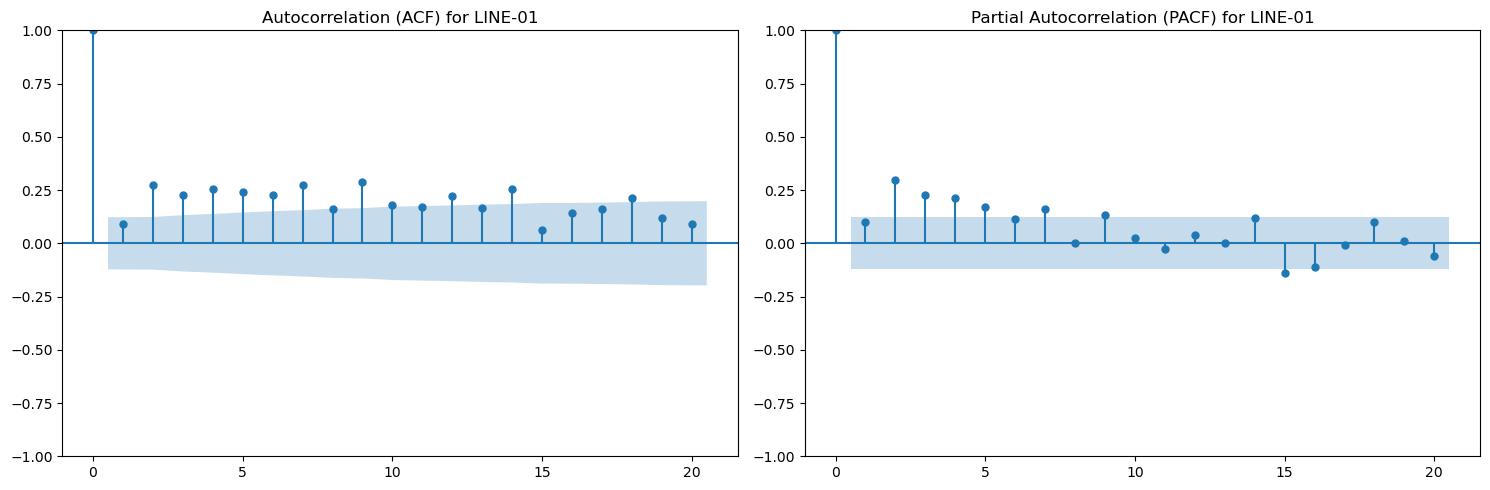


Interpretation:
ADF test (p=0.217): The OEE series for LINE-01 is likely non-stationary.
KPSS test (p=0.010): The OEE series for LINE-01 is likely non-stationary.


In [44]:
line_to_analyze = 'LINE-01'

if not per_line_dataframes:
    print("No per-line dataframes loaded. Cannot perform analysis.")
elif line_to_analyze in per_line_dataframes:
    df_selected_line = per_line_dataframes[line_to_analyze]

    if 'OEE' in df_selected_line.columns:
        # Extract the OEE series and drop any NA values which can cause issues with tests
        oee_data = df_selected_line['OEE'].dropna()

        if len(oee_data) < 4: # ADF/KPSS tests need a minimum number of observations
            print(f"Not enough OEE data points for '{line_to_analyze}' after dropping NA (found {len(oee_data)}). Skipping tests.")
        else:
            print(f"\n--- Analyzing OEE for Production Line: {line_to_analyze} ---")
            print(f"Number of OEE data points being analyzed: {len(oee_data)}")

            # ADF Test
            result_adf = adfuller(oee_data)
            print('\nADF Statistic: %f' % result_adf[0])
            print('p-value: %f' % result_adf[1])
            print('Critical Values:')
            for key, value in result_adf[4].items():
                print('\t%s: %.3f' % (key, value))

            # KPSS Test
            # regression : {'c', 'ct'}
            #   'c' : The data is stationary around a constant (default).
            #   'ct' : The data is stationary around a trend.
            # nlags : {'auto', 'legacy', int}
            #   Method to determine lags. 'auto' is recommended.
            result_kpss = kpss(oee_data, regression='c', nlags='auto')
            print('\nKPSS Statistic: %f' % result_kpss[0])
            print('p-value: %f' % result_kpss[1])
            # print('Lags Used by KPSS: %d' % result_kpss[2]) # result_kpss[2] is lags used
            print('Critical Values:')
            for key, value in result_kpss[3].items():
                print('\t%s: %.3f' % (key, value))

            # ACF and PACF Plots
            # Adjust number of lags if series is short to prevent errors
            num_lags = min(20, len(oee_data) // 2 - 1)
            if num_lags < 1:
                print("Not enough data points for meaningful ACF/PACF plots.")
            else:
                fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # Increased figure size slightly

                plot_acf(oee_data, lags=num_lags, ax=axes[0])
                axes[0].set_title(f'Autocorrelation (ACF) for {line_to_analyze}')

                # method='ols' for PACF we use Ordinary Least Squares
                plot_pacf(oee_data, lags=num_lags, ax=axes[1], method='ols')
                axes[1].set_title(f'Partial Autocorrelation (PACF) for {line_to_analyze}')

                plt.tight_layout()
                plt.show()

            # Interpretation
            print("\nInterpretation:")
            if result_adf[1] <= 0.05:
                print(f"ADF test (p={result_adf[1]:.3f}): The OEE series for {line_to_analyze} is likely stationary.")
            else:
                print(f"ADF test (p={result_adf[1]:.3f}): The OEE series for {line_to_analyze} is likely non-stationary.")

            if result_kpss[1] <= 0.05:
                print(f"KPSS test (p={result_kpss[1]:.3f}): The OEE series for {line_to_analyze} is likely non-stationary.")
            else:
                print(f"KPSS test (p={result_kpss[1]:.3f}): The OEE series for {line_to_analyze} is likely stationary.")

    else:
        print(f"Column 'OEE' not found in the DataFrame for line '{line_to_analyze}'.")
        print(f"Available columns: {df_selected_line.columns.tolist()}")
else:
    print(f"Production line '{line_to_analyze}' not found in the loaded data.")
    print(f"Available lines: {list(per_line_dataframes.keys())}")

##### Interpretation: 
Both tests agree that the OEE series for LINE-01 is likely non-stationary. This means the series probably has a trend, changing mean, or changing variance over time.
##### Next Step: 
- Differencing is recommended for this series before attempting to fit time series models like ARMA or ARIMA.
- Because the series is non-stationary, it needs to be differenced at least once to achieve stationarity before ARMA components (p,q) can be reliably identified. This means we are likely looking at an ARIMA(p,d,q) model where d >= 1.


--- Analyzing OEE for Production Line: LINE-01 ---
Number of OEE data points being analyzed: 255

ADF Statistic: -8.582600
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573

KPSS Statistic: 0.259929
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


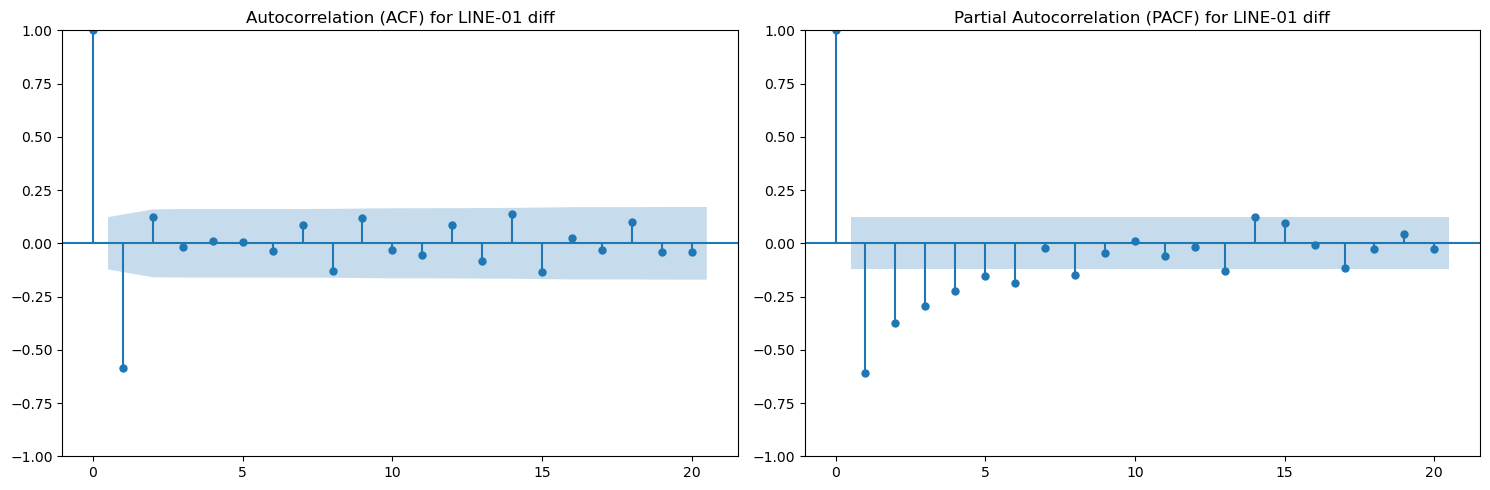


Interpretation:
ADF test (p=0.000): The OEE series for LINE-01 is likely stationary.
KPSS test (p=0.100): The OEE series for LINE-01 is likely stationary.


In [46]:
oee_data = df_selected_line['OEE'].diff().dropna()

if len(oee_data) < 4: # ADF/KPSS tests need a minimum number of observations
    print(f"Not enough OEE data points for '{line_to_analyze}' after dropping NA (found {len(oee_data)}). Skipping tests.")
else:
    print(f"\n--- Analyzing OEE for Production Line: {line_to_analyze} ---")
    print(f"Number of OEE data points being analyzed: {len(oee_data)}")

    # ADF Test
    result_adf = adfuller(oee_data)
    print('\nADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')
    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    # KPSS Test
    # regression : {'c', 'ct'}
    #   'c' : The data is stationary around a constant (default).
    #   'ct' : The data is stationary around a trend.
    # nlags : {'auto', 'legacy', int}
    #   Method to determine lags. 'auto' is recommended.
    result_kpss = kpss(oee_data, regression='c', nlags='auto')
    print('\nKPSS Statistic: %f' % result_kpss[0])
    print('p-value: %f' % result_kpss[1])
    # print('Lags Used by KPSS: %d' % result_kpss[2]) # result_kpss[2] is lags used
    print('Critical Values:')
    for key, value in result_kpss[3].items():
        print('\t%s: %.3f' % (key, value))

    # ACF and PACF Plots
    # Adjust number of lags if series is short to prevent errors
    num_lags = min(20, len(oee_data) // 2 - 1)
    if num_lags < 1:
        print("Not enough data points for meaningful ACF/PACF plots.")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # Increased figure size slightly

        plot_acf(oee_data, lags=num_lags, ax=axes[0])
        axes[0].set_title(f'Autocorrelation (ACF) for {line_to_analyze} diff')

        # method='ols' for PACF we use Ordinary Least Squares
        plot_pacf(oee_data, lags=num_lags, ax=axes[1], method='ols')
        axes[1].set_title(f'Partial Autocorrelation (PACF) for {line_to_analyze} diff')

        plt.tight_layout()
        plt.show()

    # Interpretation
    print("\nInterpretation:")
    if result_adf[1] <= 0.05:
        print(f"ADF test (p={result_adf[1]:.3f}): The OEE series for {line_to_analyze} is likely stationary.")
    else:
        print(f"ADF test (p={result_adf[1]:.3f}): The OEE series for {line_to_analyze} is likely non-stationary.")

    if result_kpss[1] <= 0.05:
        print(f"KPSS test (p={result_kpss[1]:.3f}): The OEE series for {line_to_analyze} is likely non-stationary.")
    else:
        print(f"KPSS test (p={result_kpss[1]:.3f}): The OEE series for {line_to_analyze} is likely stationary.")

Based on these plots for the differenced series, the most likely model is an ARIMA(0,1,1).
- p=0: Because the PACF of the differenced series tails off.
- d=1: Because we differenced the series once.
- q=1: Because the ACF of the differenced series cuts off sharply after lag 1.

But we will automate the search to make sure that we use the best model.

Line 3


--- Analyzing OEE for Production Line: LINE-03 ---
Number of OEE data points being analyzed: 258

ADF Statistic: -6.129523
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573

KPSS Statistic: 0.368183
p-value: 0.090869
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


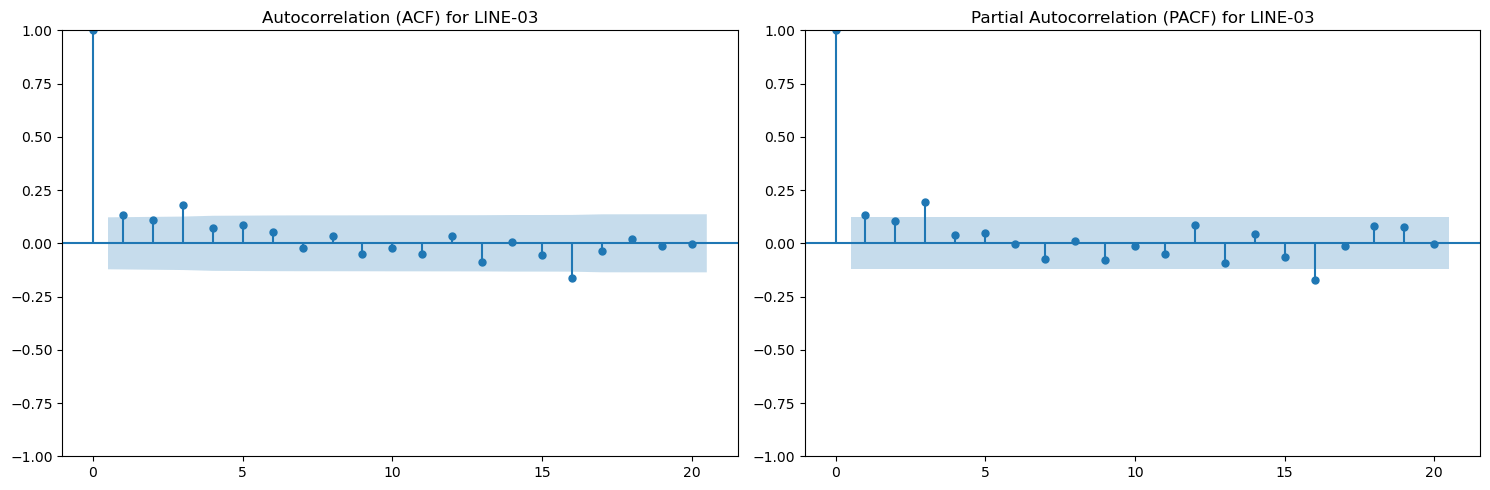


Interpretation:
ADF test (p=0.000): The OEE series for LINE-03 is likely stationary.
KPSS test (p=0.091): The OEE series for LINE-03 is likely stationary.


In [26]:
line_to_analyze = 'LINE-03'

if not per_line_dataframes:
    print("No per-line dataframes loaded. Cannot perform analysis.")
elif line_to_analyze in per_line_dataframes:
    df_selected_line = per_line_dataframes[line_to_analyze]

    if 'OEE' in df_selected_line.columns:
        # Extract the OEE series and drop any NA values which can cause issues with tests
        oee_data = df_selected_line['OEE'].dropna()

        if len(oee_data) < 4: # ADF/KPSS tests need a minimum number of observations
            print(f"Not enough OEE data points for '{line_to_analyze}' after dropping NA (found {len(oee_data)}). Skipping tests.")
        else:
            print(f"\n--- Analyzing OEE for Production Line: {line_to_analyze} ---")
            print(f"Number of OEE data points being analyzed: {len(oee_data)}")

            # ADF Test
            result_adf = adfuller(oee_data)
            print('\nADF Statistic: %f' % result_adf[0])
            print('p-value: %f' % result_adf[1])
            print('Critical Values:')
            for key, value in result_adf[4].items():
                print('\t%s: %.3f' % (key, value))

            # KPSS Test
            # regression : {'c', 'ct'}
            #   'c' : The data is stationary around a constant (default).
            #   'ct' : The data is stationary around a trend.
            # nlags : {'auto', 'legacy', int}
            #   Method to determine lags. 'auto' is recommended.
            result_kpss = kpss(oee_data, regression='c', nlags='auto')
            print('\nKPSS Statistic: %f' % result_kpss[0])
            print('p-value: %f' % result_kpss[1])
            # print('Lags Used by KPSS: %d' % result_kpss[2]) # result_kpss[2] is lags used
            print('Critical Values:')
            for key, value in result_kpss[3].items():
                print('\t%s: %.3f' % (key, value))

            # ACF and PACF Plots
            # Adjust number of lags if series is short to prevent errors
            num_lags = min(20, len(oee_data) // 2 - 1)
            if num_lags < 1:
                print("Not enough data points for meaningful ACF/PACF plots.")
            else:
                fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # Increased figure size slightly

                plot_acf(oee_data, lags=num_lags, ax=axes[0])
                axes[0].set_title(f'Autocorrelation (ACF) for {line_to_analyze}')

                # method='ols' for PACF we use Ordinary Least Squares
                plot_pacf(oee_data, lags=num_lags, ax=axes[1], method='ols')
                axes[1].set_title(f'Partial Autocorrelation (PACF) for {line_to_analyze}')

                plt.tight_layout()
                plt.show()

            # Interpretation
            print("\nInterpretation:")
            if result_adf[1] <= 0.05:
                print(f"ADF test (p={result_adf[1]:.3f}): The OEE series for {line_to_analyze} is likely stationary.")
            else:
                print(f"ADF test (p={result_adf[1]:.3f}): The OEE series for {line_to_analyze} is likely non-stationary.")

            if result_kpss[1] <= 0.05:
                print(f"KPSS test (p={result_kpss[1]:.3f}): The OEE series for {line_to_analyze} is likely non-stationary.")
            else:
                print(f"KPSS test (p={result_kpss[1]:.3f}): The OEE series for {line_to_analyze} is likely stationary.")

    else:
        print(f"Column 'OEE' not found in the DataFrame for line '{line_to_analyze}'.")
        print(f"Available columns: {df_selected_line.columns.tolist()}")
else:
    print(f"Production line '{line_to_analyze}' not found in the loaded data.")
    print(f"Available lines: {list(per_line_dataframes.keys())}")

##### Interpretation: 
Both tests agree that the OEE series for LINE-03 is likely stationary. This implies the series fluctuates around a constant mean and has a constant variance.
##### Next Step: 
- The series can likely be modeled directly using ARMA models without prior differencing.
- ACF/PACF suggested p and q might go up to around 2, maybe with a lag 6 influence.

Line 4


--- Analyzing OEE for Production Line: LINE-04 ---
Number of OEE data points being analyzed: 251

ADF Statistic: -6.211444
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573

KPSS Statistic: 0.194400
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


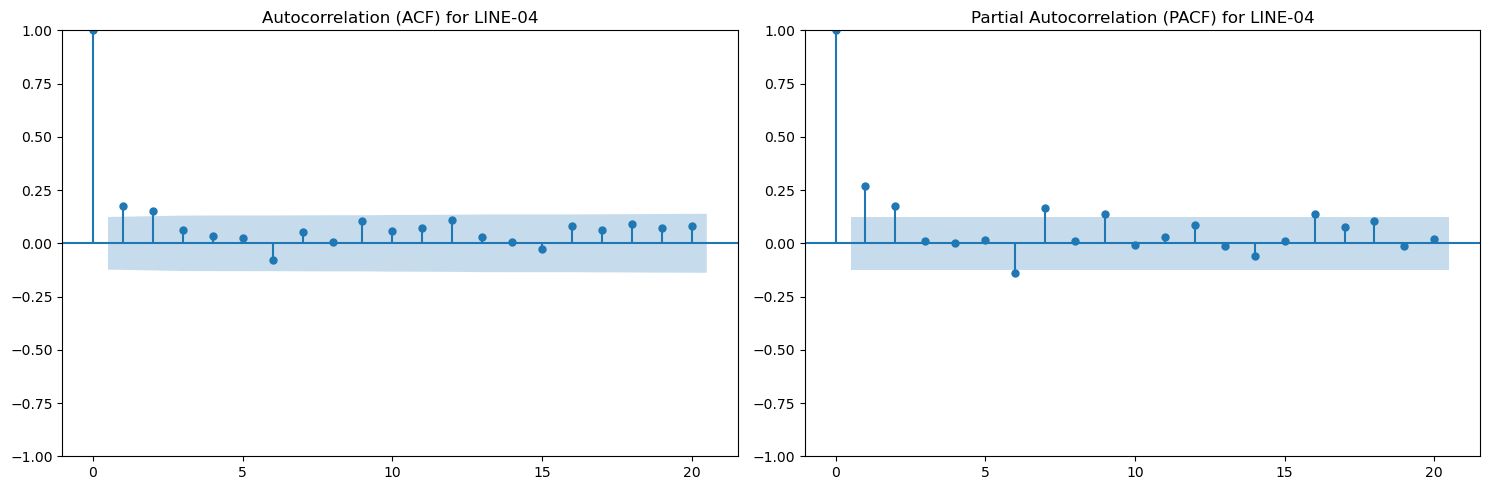


Interpretation:
ADF test (p=0.000): The OEE series for LINE-04 is likely stationary.
KPSS test (p=0.100): The OEE series for LINE-04 is likely stationary.


In [27]:
line_to_analyze = 'LINE-04'

if not per_line_dataframes:
    print("No per-line dataframes loaded. Cannot perform analysis.")
elif line_to_analyze in per_line_dataframes:
    df_selected_line = per_line_dataframes[line_to_analyze]

    if 'OEE' in df_selected_line.columns:
        # Extract the OEE series and drop any NA values which can cause issues with tests
        oee_data = df_selected_line['OEE'].dropna()

        if len(oee_data) < 4: # ADF/KPSS tests need a minimum number of observations
            print(f"Not enough OEE data points for '{line_to_analyze}' after dropping NA (found {len(oee_data)}). Skipping tests.")
        else:
            print(f"\n--- Analyzing OEE for Production Line: {line_to_analyze} ---")
            print(f"Number of OEE data points being analyzed: {len(oee_data)}")

            # ADF Test
            result_adf = adfuller(oee_data)
            print('\nADF Statistic: %f' % result_adf[0])
            print('p-value: %f' % result_adf[1])
            print('Critical Values:')
            for key, value in result_adf[4].items():
                print('\t%s: %.3f' % (key, value))

            # KPSS Test
            # regression : {'c', 'ct'}
            #   'c' : The data is stationary around a constant (default).
            #   'ct' : The data is stationary around a trend.
            # nlags : {'auto', 'legacy', int}
            #   Method to determine lags. 'auto' is recommended.
            result_kpss = kpss(oee_data, regression='c', nlags='auto')
            print('\nKPSS Statistic: %f' % result_kpss[0])
            print('p-value: %f' % result_kpss[1])
            # print('Lags Used by KPSS: %d' % result_kpss[2]) # result_kpss[2] is lags used
            print('Critical Values:')
            for key, value in result_kpss[3].items():
                print('\t%s: %.3f' % (key, value))

            # ACF and PACF Plots
            # Adjust number of lags if series is short to prevent errors
            num_lags = min(20, len(oee_data) // 2 - 1)
            if num_lags < 1:
                print("Not enough data points for meaningful ACF/PACF plots.")
            else:
                fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # Increased figure size slightly

                plot_acf(oee_data, lags=num_lags, ax=axes[0])
                axes[0].set_title(f'Autocorrelation (ACF) for {line_to_analyze}')

                # method='ols' for PACF we use Ordinary Least Squares
                plot_pacf(oee_data, lags=num_lags, ax=axes[1], method='ols')
                axes[1].set_title(f'Partial Autocorrelation (PACF) for {line_to_analyze}')

                plt.tight_layout()
                plt.show()

            # Interpretation
            print("\nInterpretation:")
            if result_adf[1] <= 0.05:
                print(f"ADF test (p={result_adf[1]:.3f}): The OEE series for {line_to_analyze} is likely stationary.")
            else:
                print(f"ADF test (p={result_adf[1]:.3f}): The OEE series for {line_to_analyze} is likely non-stationary.")

            if result_kpss[1] <= 0.05:
                print(f"KPSS test (p={result_kpss[1]:.3f}): The OEE series for {line_to_analyze} is likely non-stationary.")
            else:
                print(f"KPSS test (p={result_kpss[1]:.3f}): The OEE series for {line_to_analyze} is likely stationary.")

    else:
        print(f"Column 'OEE' not found in the DataFrame for line '{line_to_analyze}'.")
        print(f"Available columns: {df_selected_line.columns.tolist()}")
else:
    print(f"Production line '{line_to_analyze}' not found in the loaded data.")
    print(f"Available lines: {list(per_line_dataframes.keys())}")

##### Interpretation: 
Both tests agree that the OEE series for LINE-04 is likely stationary.
##### Next Step: 
- Similar to LINE-03, this series can likely be modeled directly using ARMA models
- The ACF cutting off after lag 2 suggests q=2.
- The PACF cutting off after lag 2 suggests p=2.

The visual evidence isn't overwhelmingly pointing to a pure AR or pure MA process since neither clearly "tails off" while the other cuts off.
- We will use the results to guide the automated search.

Line 6


--- Analyzing OEE for Production Line: LINE-06 ---
Number of OEE data points being analyzed: 251

ADF Statistic: -8.544489
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573

KPSS Statistic: 0.212891
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


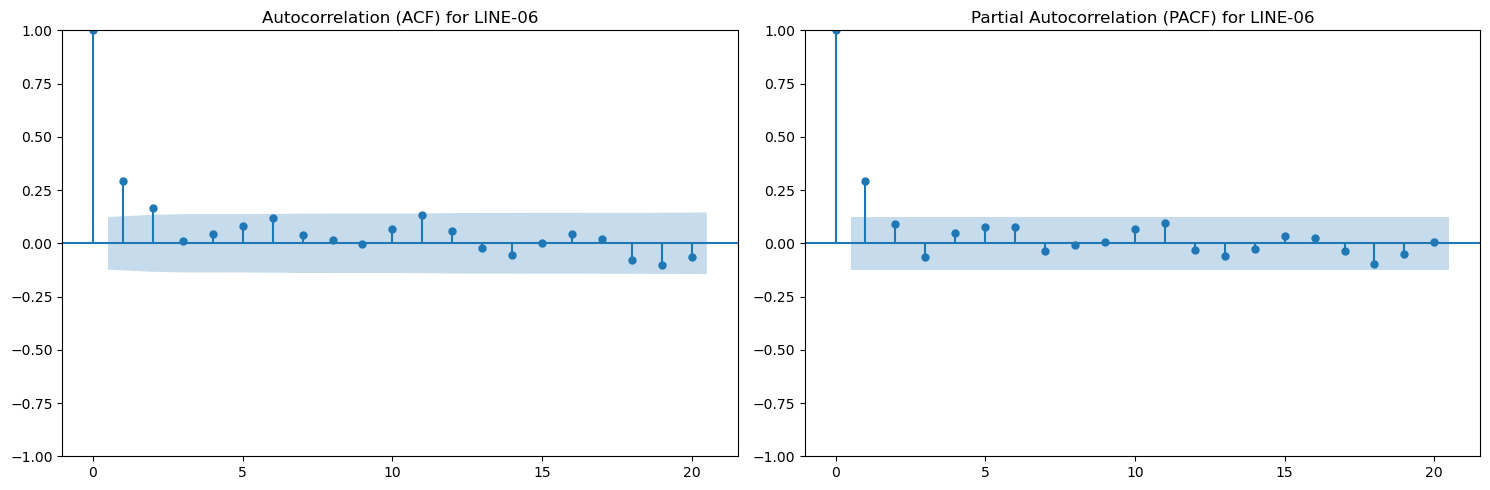


Interpretation:
ADF test (p=0.000): The OEE series for LINE-06 is likely stationary.
KPSS test (p=0.100): The OEE series for LINE-06 is likely stationary.


In [28]:
line_to_analyze = 'LINE-06'

if not per_line_dataframes:
    print("No per-line dataframes loaded. Cannot perform analysis.")
elif line_to_analyze in per_line_dataframes:
    df_selected_line = per_line_dataframes[line_to_analyze]

    if 'OEE' in df_selected_line.columns:
        # Extract the OEE series and drop any NA values which can cause issues with tests
        oee_data = df_selected_line['OEE'].dropna()

        if len(oee_data) < 4: # ADF/KPSS tests need a minimum number of observations
            print(f"Not enough OEE data points for '{line_to_analyze}' after dropping NA (found {len(oee_data)}). Skipping tests.")
        else:
            print(f"\n--- Analyzing OEE for Production Line: {line_to_analyze} ---")
            print(f"Number of OEE data points being analyzed: {len(oee_data)}")

            # ADF Test
            result_adf = adfuller(oee_data)
            print('\nADF Statistic: %f' % result_adf[0])
            print('p-value: %f' % result_adf[1])
            print('Critical Values:')
            for key, value in result_adf[4].items():
                print('\t%s: %.3f' % (key, value))

            # KPSS Test
            # regression : {'c', 'ct'}
            #   'c' : The data is stationary around a constant (default).
            #   'ct' : The data is stationary around a trend.
            # nlags : {'auto', 'legacy', int}
            #   Method to determine lags. 'auto' is recommended.
            result_kpss = kpss(oee_data, regression='c', nlags='auto')
            print('\nKPSS Statistic: %f' % result_kpss[0])
            print('p-value: %f' % result_kpss[1])
            # print('Lags Used by KPSS: %d' % result_kpss[2]) # result_kpss[2] is lags used
            print('Critical Values:')
            for key, value in result_kpss[3].items():
                print('\t%s: %.3f' % (key, value))

            # ACF and PACF Plots
            # Adjust number of lags if series is short to prevent errors
            num_lags = min(20, len(oee_data) // 2 - 1)
            if num_lags < 1:
                print("Not enough data points for meaningful ACF/PACF plots.")
            else:
                fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # Increased figure size slightly

                plot_acf(oee_data, lags=num_lags, ax=axes[0])
                axes[0].set_title(f'Autocorrelation (ACF) for {line_to_analyze}')

                # method='ols' for PACF we use Ordinary Least Squares
                plot_pacf(oee_data, lags=num_lags, ax=axes[1], method='ols')
                axes[1].set_title(f'Partial Autocorrelation (PACF) for {line_to_analyze}')

                plt.tight_layout()
                plt.show()

            # Interpretation
            print("\nInterpretation:")
            if result_adf[1] <= 0.05:
                print(f"ADF test (p={result_adf[1]:.3f}): The OEE series for {line_to_analyze} is likely stationary.")
            else:
                print(f"ADF test (p={result_adf[1]:.3f}): The OEE series for {line_to_analyze} is likely non-stationary.")

            if result_kpss[1] <= 0.05:
                print(f"KPSS test (p={result_kpss[1]:.3f}): The OEE series for {line_to_analyze} is likely non-stationary.")
            else:
                print(f"KPSS test (p={result_kpss[1]:.3f}): The OEE series for {line_to_analyze} is likely stationary.")

    else:
        print(f"Column 'OEE' not found in the DataFrame for line '{line_to_analyze}'.")
        print(f"Available columns: {df_selected_line.columns.tolist()}")
else:
    print(f"Production line '{line_to_analyze}' not found in the loaded data.")
    print(f"Available lines: {list(per_line_dataframes.keys())}")

##### Interpretation: 
- Both tests agree that the OEE series for LINE-06 is likely stationary.
- The ACF cutting off after lag 2 suggests an MA(2) component (so q=2).
- The PACF cutting off after lag 1 suggests an AR(1) component (so p=1).
##### Next Step: 
- This series also appears suitable for direct modeling with ARMA models.
- Based on these plots, the most likely model is an ARMA(1,2).
* p=1: From the PACF cut-off.
* d=0: Because the series is stationary.
* q=2: From the ACF cut-off.

We will use the results to guide the automated search.

overall oee


--- Analyzing Overall Plant OEE ---
Number of Overall OEE data points being analyzed: 258

Overall ADF Statistic: -3.353842
Overall p-value: 0.012637
Overall Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573

Overall KPSS Statistic: 0.354675
Overall p-value: 0.096692
Overall Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


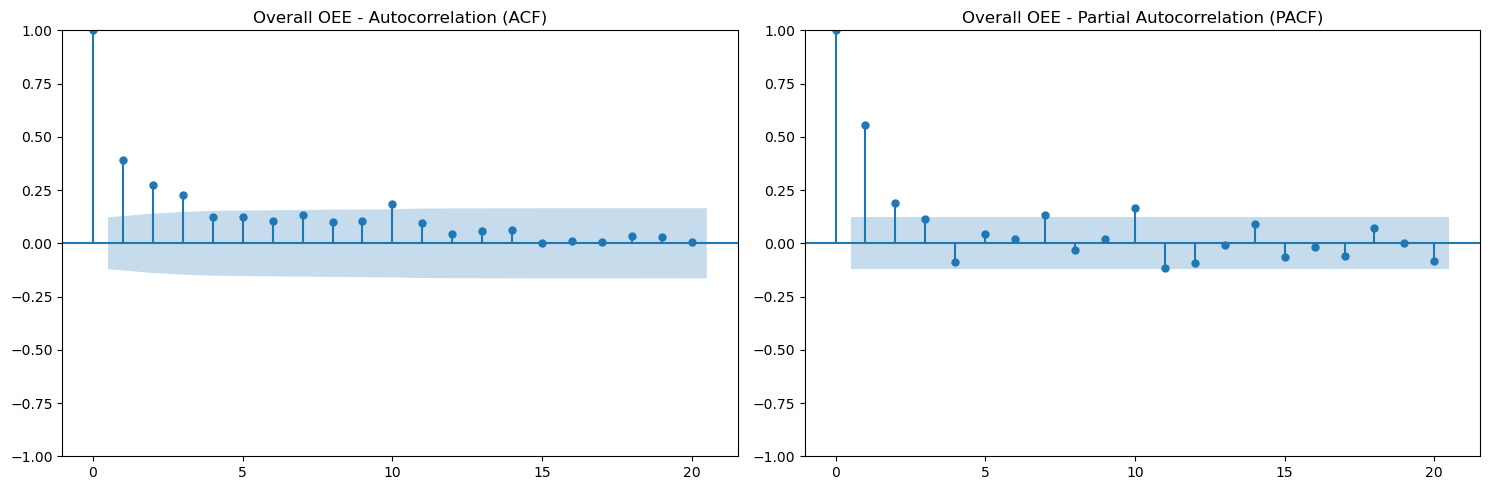


Overall OEE Interpretation:
ADF test (p=0.013): The Overall OEE series is likely stationary.
KPSS test (p=0.097): The Overall OEE series is likely stationary.


In [29]:
if df_overall is not None and not df_overall.empty:
    if 'OEE' in df_overall.columns:
        # Extract the OEE series and drop any NA values
        oee_data_overall = df_overall['OEE'].dropna()

        if len(oee_data_overall) < 4: # Minimum observations for tests
            print(f"Not enough Overall OEE data points after dropping NA (found {len(oee_data_overall)}). Skipping tests.")
        else:
            print(f"\n--- Analyzing Overall Plant OEE ---")
            print(f"Number of Overall OEE data points being analyzed: {len(oee_data_overall)}")

            # ADF Test
            result_adf_overall = adfuller(oee_data_overall)
            print('\nOverall ADF Statistic: %f' % result_adf_overall[0])
            print('Overall p-value: %f' % result_adf_overall[1])
            print('Overall Critical Values:')
            for key, value in result_adf_overall[4].items():
                print('\t%s: %.3f' % (key, value))

            # KPSS Test
            result_kpss_overall = kpss(oee_data_overall, regression='c', nlags='auto')
            print('\nOverall KPSS Statistic: %f' % result_kpss_overall[0])
            print('Overall p-value: %f' % result_kpss_overall[1])
            print('Overall Critical Values:')
            for key, value in result_kpss_overall[3].items():
                print('\t%s: %.3f' % (key, value))

            # ACF and PACF Plots
            num_lags_overall = min(20, len(oee_data_overall) // 2 - 1)
            if num_lags_overall < 1:
                print("Not enough data points for meaningful Overall ACF/PACF plots.")
            else:
                fig_overall, axes_overall = plt.subplots(1, 2, figsize=(15, 5))

                plot_acf(oee_data_overall, lags=num_lags_overall, ax=axes_overall[0])
                axes_overall[0].set_title('Overall OEE - Autocorrelation (ACF)')

                plot_pacf(oee_data_overall, lags=num_lags_overall, ax=axes_overall[1], method='ols')
                axes_overall[1].set_title('Overall OEE - Partial Autocorrelation (PACF)')

                plt.tight_layout()
                plt.show()

            # Interpretation for Overall OEE
            print("\nOverall OEE Interpretation:")
            if result_adf_overall[1] <= 0.05:
                print(f"ADF test (p={result_adf_overall[1]:.3f}): The Overall OEE series is likely stationary.")
            else:
                print(f"ADF test (p={result_adf_overall[1]:.3f}): The Overall OEE series is likely non-stationary.")

            if result_kpss_overall[1] <= 0.05:
                print(f"KPSS test (p={result_kpss_overall[1]:.3f}): The Overall OEE series is likely non-stationary.")
            else:
                print(f"KPSS test (p={result_kpss_overall[1]:.3f}): The Overall OEE series is likely stationary.")
    else:
        print("Column 'OEE' not found in the 'df_overall' DataFrame.")
        if df_overall is not None:
             print(f"Available columns in df_overall: {df_overall.columns.tolist()}")
else:
    print("'df_overall' is not loaded or is empty. Cannot perform analysis.")

##### Interpretation: 
Both tests agree that the OEE series for LINE-03 is likely stationary. This implies the series fluctuates around a constant mean and has a constant variance.
##### Next Step: 
- The series can likely be modeled directly using ARMA models without prior differencing.
- The pattern (ACF tails off, PACF cuts off after lag p) is classic for an Autoregressive AR(p) process.
* p is likely 2 or 3 (from the PACF cut-off).
* d=0 (because the series is stationary).
* q=0 (because the ACF tails off, not cuts off, suggesting no strong MA component is needed if it's a pure AR process).

This points towards an ARMA(2,0) or ARMA(3,0) model (i.e., AR(2) or AR(3)).

automated search


--- Running auto_arima for LINE-01 OEE data (original series) ---
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.766, Time=1.98 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-145.206, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-215.661, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.704, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-225.128, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-223.432, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-223.672, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-225.671, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-227.250, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-216.992, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-225.254, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-226.655, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 6.190 seconds

--- Best model found f

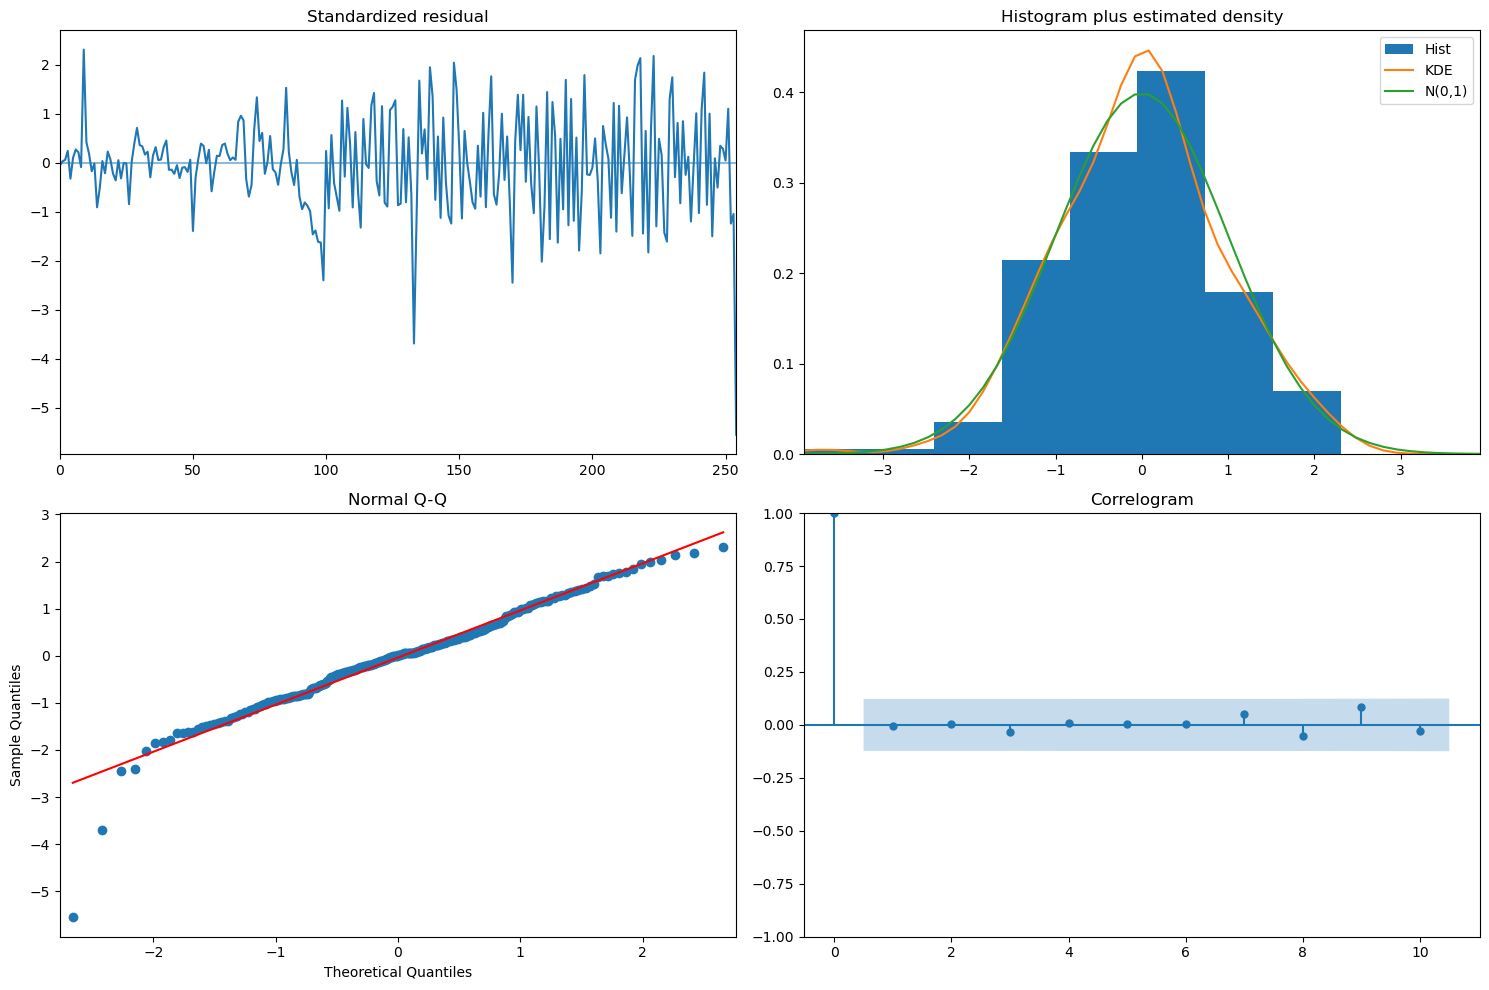

In [54]:
line_to_analyze = 'LINE-01'

if line_to_analyze in per_line_dataframes:
    df_selected_line = per_line_dataframes[line_to_analyze]
    if 'OEE' in df_selected_line.columns:
        # Use the original, non-stationary OEE data for LINE-01
        oee_data_line01_original = df_selected_line['OEE'].dropna()

        if len(oee_data_line01_original) > 10: # auto_arima needs a reasonable number of data points
            print(f"\n--- Running auto_arima for {line_to_analyze} OEE data (original series) ---")

            # Let auto_arima determine 'd'
            # Based on ACF/PACF of differenced series, we expect something like (0,1,1) or (p,1,q)
            # We can set start_p, max_p, start_q, max_q to guide the search.
            # Since the differenced PACF tailed off, p is likely small (0 or 1).
            # Since the differenced ACF cut off at 1 (or 2), q is likely 1 (or 2).
            model_line01 = pm.auto_arima(oee_data_line01_original,
                                         start_p=0, max_p=2,        # Max AR order to test for the differenced series
                                         start_q=0, max_q=2,        # Max MA order to test for the differenced series
                                         d=None,                   # Let auto_arima find the best 'd'
                                         max_d=2,                  # Allow up to 2 orders of differencing
                                         seasonal=False,           # No seasonality for now
                                         stepwise=True,            # Use efficient stepwise search
                                         suppress_warnings=True,   # Suppress convergence warnings
                                         trace=True,               # Print results of each model tried
                                         error_action='ignore',    # Ignore errors from bad models
                                         # Test for stationarity using KPSS by default, can specify others
                                         # test='adf', # or 'kpss', 'pp'
                                         # Information criterion to minimize (AIC is default)
                                         # information_criterion='bic' # or 'aic', 'hqic', 'oob'
                                        )

            print(f"\n--- Best model found for {line_to_analyze} by auto_arima ---")
            print(model_line01.summary())

            print(f"\n--- Plotting diagnostics for the best model of {line_to_analyze} ---")
            # Ensure the figure size is adequate for readability
            fig_diag_line01 = model_line01.plot_diagnostics(figsize=(15, 10))
            plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
            plt.show()

        else:
            print(f"Not enough data points for {line_to_analyze} to run auto_arima effectively.")
    else:
        print(f"OEE column not found for {line_to_analyze}")
else:
    print(f"Data for {line_to_analyze} not found in per_line_dataframes.")


--- Running auto_arima for LINE-03 OEE data ---
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=672.155, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-287.097, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=389.508, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-424.044, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-424.197, Time=0.32 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-419.911, Time=0.72 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-420.048, Time=0.47 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-423.748, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-439.045, Time=0.70 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-440.096, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-434.484, Time=0.09 sec
 

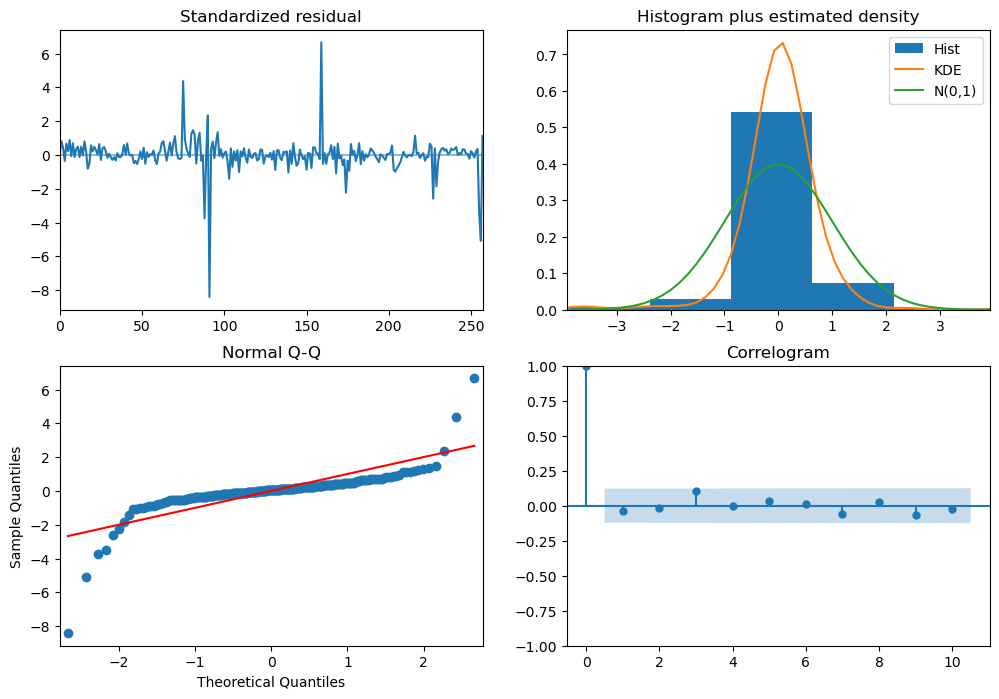

In [55]:
line_to_analyze = 'LINE-03'

if line_to_analyze in per_line_dataframes:
    df_selected_line = per_line_dataframes[line_to_analyze]
    if 'OEE' in df_selected_line.columns:
        oee_data_line03 = df_selected_line['OEE'].dropna()

        if len(oee_data_line03) > 10: # auto_arima needs a reasonable number of data points
            print(f"\n--- Running auto_arima for {line_to_analyze} OEE data ---")
            # Since LINE-03 was found to be stationary, we can guide auto_arima
            # by setting d=0 and max_d=0.
            # We'll also set seasonal=False as we are looking for ARMA/ARIMA.

            # For LINE-03, ACF/PACF suggested p and q might go up to around 2, maybe with a lag 6 influence.
            model_line03 = pm.auto_arima(oee_data_line03,
                                         start_p=0, max_p=5, # Max AR order
                                         start_q=0, max_q=5, # Max MA order
                                         d=0,              # Forcing d=0 as series is stationary
                                         max_d=0,          
                                         seasonal=False,     # No seasonality for now
                                         stepwise=True,      # Uses a stepwise algorithm to find best model (faster)
                                         suppress_warnings=True, # Suppress convergence warnings
                                         trace=True,         # Print results of each model tried
                                         error_action='ignore') # Ignore errors from bad models

            print(f"\n--- Best model found for {line_to_analyze} by auto_arima ---")
            print(model_line03.summary())

            # Check residuals of the chosen model
            print(f"\n--- Plotting diagnostics for the best model of {line_to_analyze} ---")
            model_line03.plot_diagnostics(figsize=(12, 8))
            plt.show()

        else:
            print(f"Not enough data points for {line_to_analyze} to run auto_arima effectively.")
    else:
        print(f"OEE column not found for {line_to_analyze}")
else:
    print(f"Data for {line_to_analyze} not found in per_line_dataframes.")


--- Running auto_arima for LINE-04 OEE data ---
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=651.281, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=350.240, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-472.941, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-474.884, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-475.242, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-472.493, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-470.356, Time=0.50 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-481.812, Time=0.42 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-483.805, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-484.889, Time=0.54 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-479.407, Time=0.15 sec
 

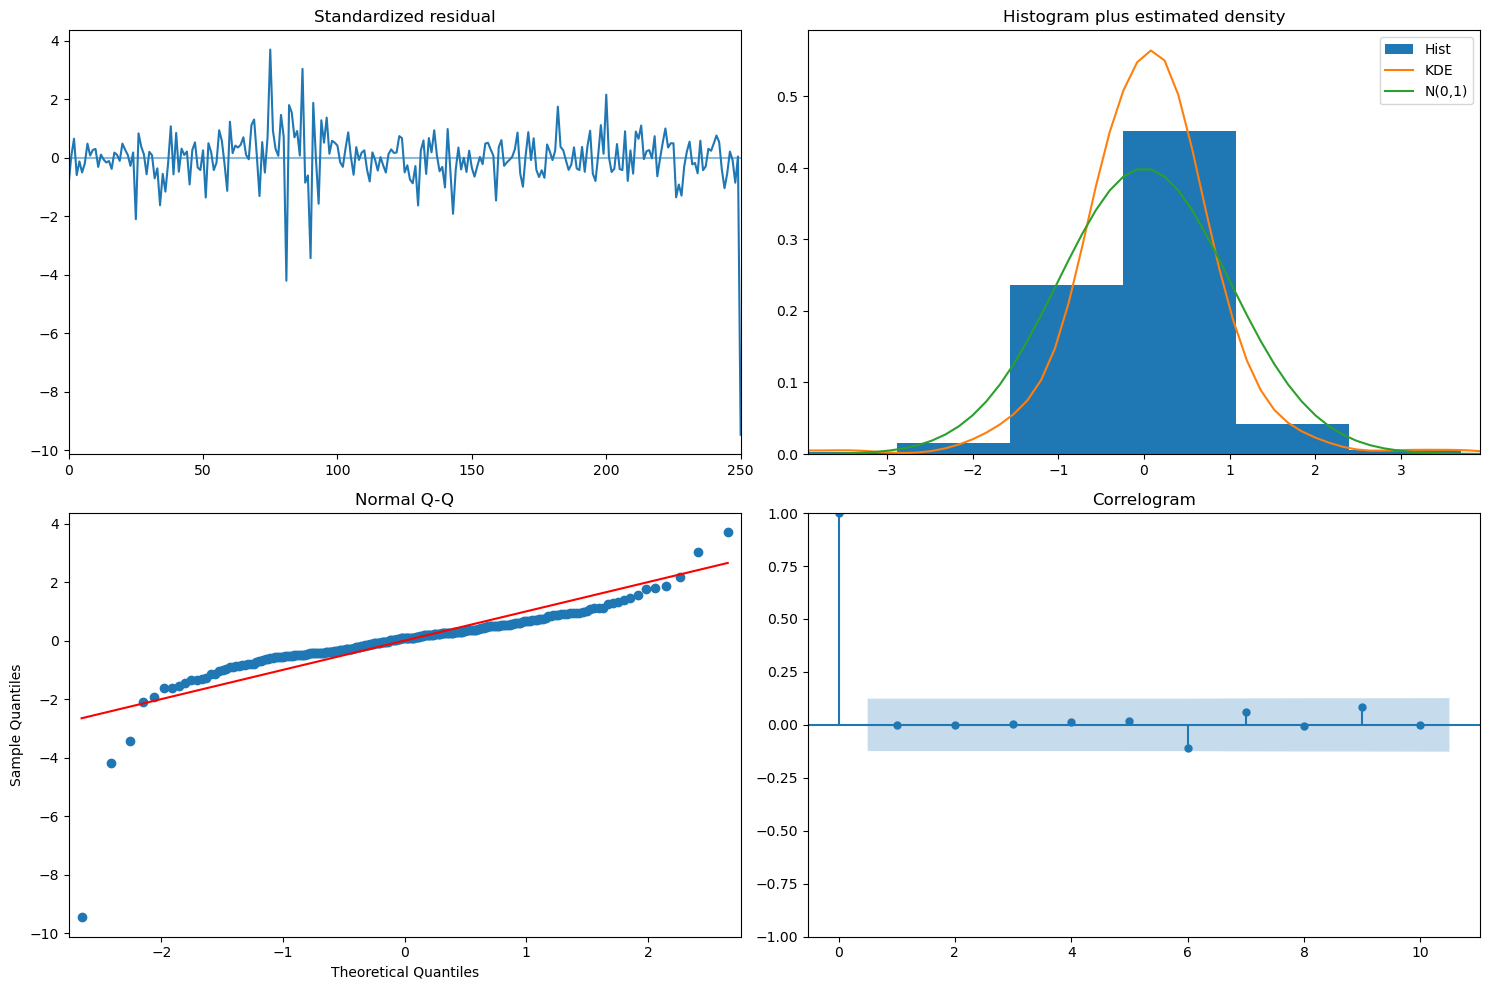

In [56]:
line_to_analyze = 'LINE-04'

if line_to_analyze in per_line_dataframes:
    df_selected_line = per_line_dataframes[line_to_analyze]
    if 'OEE' in df_selected_line.columns:
        oee_data_line04 = df_selected_line['OEE'].dropna()

        if len(oee_data_line04) > 10:
            print(f"\n--- Running auto_arima for {line_to_analyze} OEE data ---")

            # LINE-04 is stationary, so d=0.
            # ACF/PACF suggest p and q might be around 2.
            # Let's give auto_arima a search space up to p=3, q=3.
            model_line04 = pm.auto_arima(oee_data_line04,
                                         start_p=0, max_p=3,
                                         start_q=0, max_q=3,
                                         d=0,              # Forcing d=0 as series is stationary
                                         max_d=0,          
                                         seasonal=False,
                                         stepwise=True,
                                         suppress_warnings=True,
                                         trace=True,
                                         error_action='ignore')

            print(f"\n--- Best model found for {line_to_analyze} by auto_arima ---")
            print(model_line04.summary())

            print(f"\n--- Plotting diagnostics for the best model of {line_to_analyze} ---")
            fig_diag_line04 = model_line04.plot_diagnostics(figsize=(15, 10))
            plt.tight_layout()
            plt.show()

        else:
            print(f"Not enough data points for {line_to_analyze} to run auto_arima effectively.")
    else:
        print(f"OEE column not found for {line_to_analyze}")
else:
    print(f"Data for {line_to_analyze} not found in per_line_dataframes.")


--- Running auto_arima for LINE-06 OEE data ---
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=647.744, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=358.681, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-525.677, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-537.222, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-537.496, Time=0.43 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.49 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-547.302, Time=0.91 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-548.527, Time=0.42 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-549.485, Time=0.47 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-545.267, Time=0.09 sec
 ARIMA(1,0,

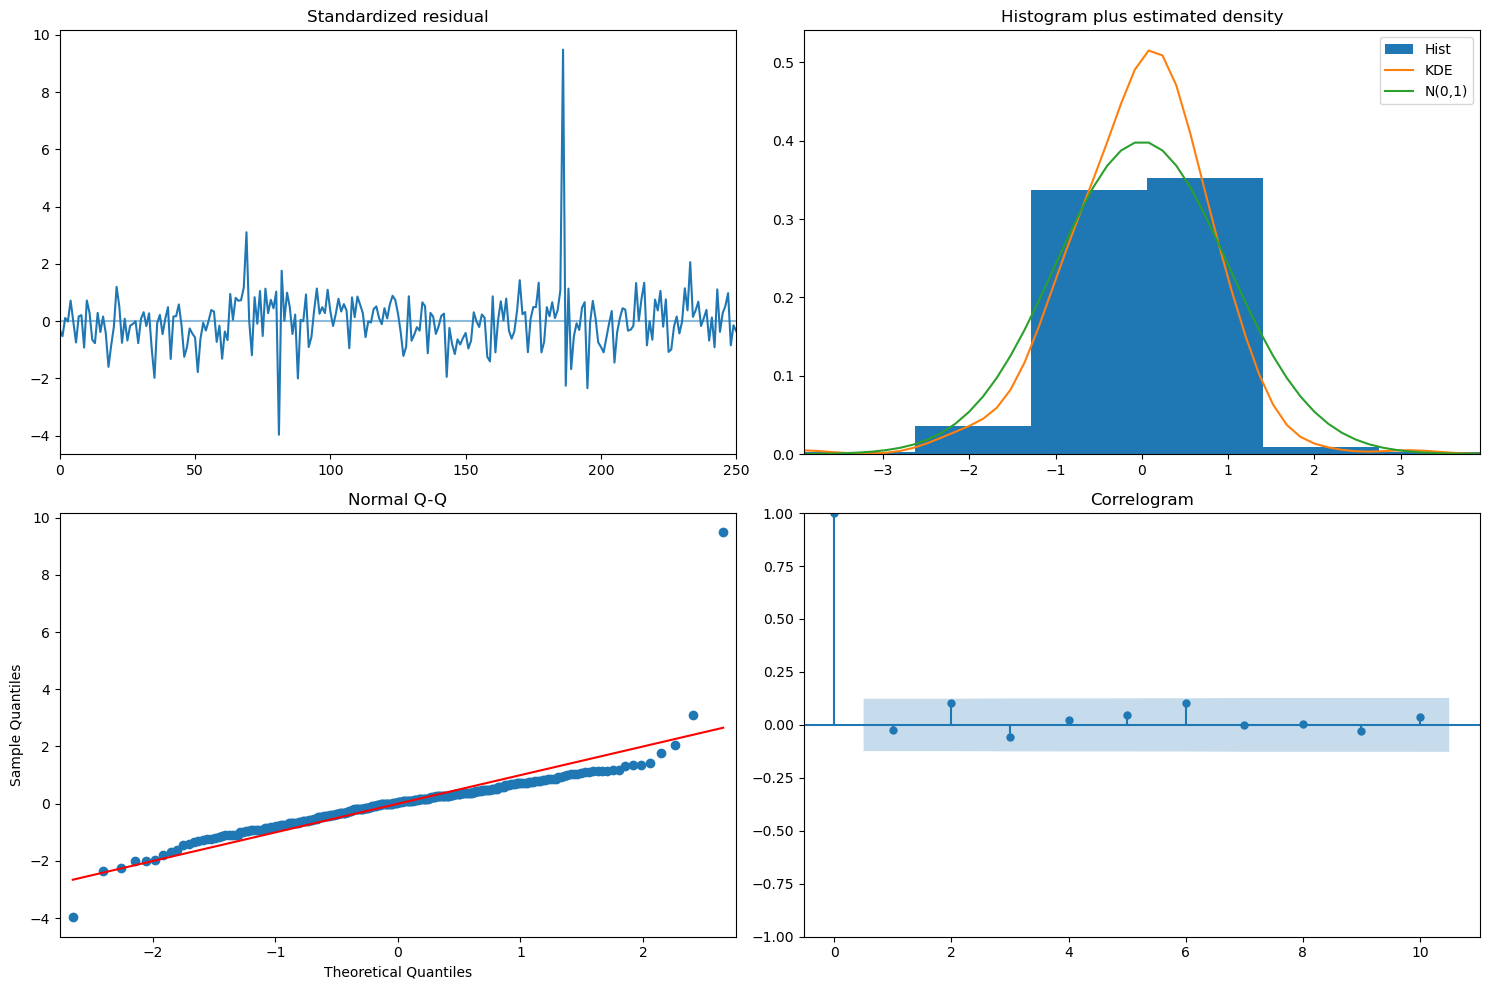

In [57]:
line_to_analyze = 'LINE-06'

if line_to_analyze in per_line_dataframes:
    df_selected_line = per_line_dataframes[line_to_analyze]
    if 'OEE' in df_selected_line.columns:
        oee_data_line06 = df_selected_line['OEE'].dropna()

        if len(oee_data_line06) > 10:
            print(f"\n--- Running auto_arima for {line_to_analyze} OEE data ---")

            # LINE-06 is stationary, so d=0.
            # ACF suggests q=2, PACF suggests p=1.
            # Let's give auto_arima a search space that comfortably includes ARMA(1,2).
            # max_p=2 or 3, max_q=2 or 3 should be sufficient.
            model_line06 = pm.auto_arima(oee_data_line06,
                                         start_p=0, max_p=3,
                                         start_q=0, max_q=3,
                                         d=0,              # Forcing d=0 as series is stationary
                                         max_d=0,          
                                         seasonal=False,
                                         stepwise=True,
                                         suppress_warnings=True,
                                         trace=True,
                                         error_action='ignore')

            print(f"\n--- Best model found for {line_to_analyze} by auto_arima ---")
            print(model_line06.summary())

            print(f"\n--- Plotting diagnostics for the best model of {line_to_analyze} ---")
            fig_diag_line06 = model_line06.plot_diagnostics(figsize=(15, 10))
            plt.tight_layout()
            plt.show()

        else:
            print(f"Not enough data points for {line_to_analyze} to run auto_arima effectively.")
    else:
        print(f"OEE column not found for {line_to_analyze}")
else:
    print(f"Data for {line_to_analyze} not found in per_line_dataframes.")


--- Running auto_arima for Overall OEE data (confirmed stationary) ---
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=797.247, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=485.411, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-371.479, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-370.828, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-371.460, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=291.641, Time=0.51 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-369.826, Time=0.64 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-383.744, Time=0.57 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-358.309, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-378.156, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-381.750, Time=0.88 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AI

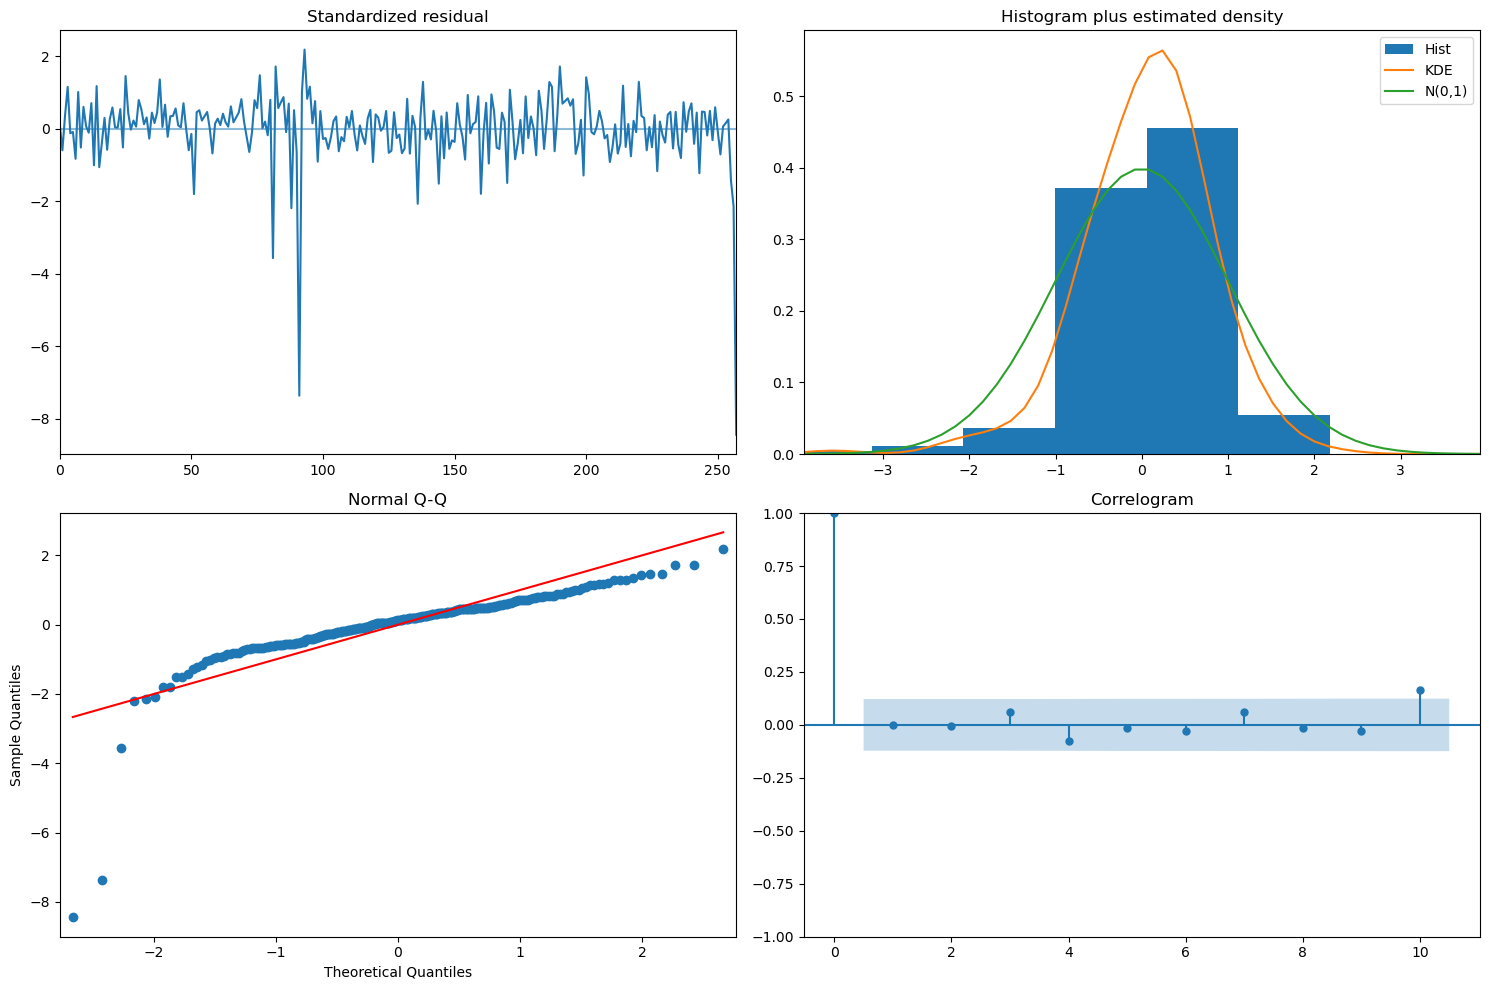

In [58]:
if 'df_overall' in locals() and df_overall is not None and 'OEE' in df_overall.columns:
    oee_data_overall = df_overall['OEE'].dropna()

    if len(oee_data_overall) > 10:
        print(f"\n--- Running auto_arima for Overall OEE data (confirmed stationary) ---")

        # Overall OEE is stationary, so d=0.
        # PACF suggests p=2 or p=3. ACF tails off, suggesting q=0.
        # Let's give auto_arima a search space that covers AR(2), AR(3)
        # and allows for small MA terms if they improve the model.
        model_overall_oee = pm.auto_arima(oee_data_overall,
                                          start_p=0, max_p=4,    # Max AR order, allowing up to AR(4)
                                          start_q=0, max_q=2,    # Max MA order, allowing for ARMA(p,1) or ARMA(p,2)
                                          d=0,                  # Forcing d=0 as series is stationary
                                          max_d=0,              
                                          seasonal=False,
                                          stepwise=True,
                                          suppress_warnings=True,
                                          trace=True,
                                          error_action='ignore')

        print(f"\n--- Best model found for Overall OEE by auto_arima ---")
        print(model_overall_oee.summary())

        print(f"\n--- Plotting diagnostics for the best model of Overall OEE ---")
        fig_diag_overall = model_overall_oee.plot_diagnostics(figsize=(15, 10))
        plt.tight_layout()
        plt.show()

    else:
        print(f"Not enough data points for Overall OEE to run auto_arima effectively.")
else:
    print("Overall OEE data ('df_overall' with 'OEE' column) not found or is empty.")

# Walk-Forward Validation Function

The `walk_forward_validation` function:
- Takes the series name, the full original data, the parameters of the best model (order and seasonal_order), and the number of test periods.
- Splits Data: Divides the original_data into train_data and test_data.
- history list: Initialized with the train_data. This list will grow as we incorporate actual values from the test_data.

## Loop through test_data:
- Fit Model: Inside the loop, a new pm.ARIMA model is instantiated and fitted using the current history. This simulates retraining the model with all available data up to that point.
- Note on pm.ARIMA vs auto_arima: We use pm.ARIMA here because we already know the best order from auto_arima. Re-running auto_arima at each step would be too slow. We are assuming the model structure (p,d,q orders) remains optimal, and we are just re-estimating the coefficients with new data.
- Alternative with model.update(): If you have the pmdarima model object from auto_arima (e.g., model_line01), you could potentially use model_line01.update(new_observation) instead of a full fit. This is faster as it updates coefficients without re-searching orders. However, for robustness and to closely mimic re-evaluation, re-fitting with pm.ARIMA is often preferred in validation loops if computationally feasible. The provided code uses pm.ARIMA for clarity on using the determined orders.
- Predict One Step: current_model.predict(n_periods=1) forecasts the very next value.
- Store Prediction and Actual: The prediction (yhat) and the actual observation (obs) from test_data are stored.
- Update History: The actual obs is appended to the history list, so the next iteration's model fitting will include this new real data point.
- Calculate Metrics: After the loop, MAE and RMSE are calculated between the actuals and predictions.
- Plot Results: A plot is generated showing the actual vs. predicted values over the test period.

## model_..._params Dictionaries:
CRITICAL: You must replace the placeholder {'order': (p,d,q), 'seasonal_order': (P,D,Q,m)} dictionaries with the actual orders determined by your auto_arima runs for each specific line and for the overall OEE.

If your auto_arima model object is, for example, model_line01_fitted_by_auto_arima, you can get its parameters like this:
```python
model_line01_params = {
    'order': model_line01_fitted_by_auto_arima.order,
    'seasonal_order': model_line01_fitted_by_auto_arima.seasonal_order
}
```

In [62]:
# --- Configuration ---
N_TEST_PERIODS = 30 # Number of days to use for walk-forward validation (e.g., last 30 days)

# --- Function to perform walk-forward validation ---
def walk_forward_validation(series_name, original_data, fitted_model_params, n_test_periods):
    """
    Performs walk-forward validation for a given time series and ARIMA model parameters.

    Args:
        series_name (str): Name of the time series (e.g., "LINE-01", "Overall OEE").
        original_data (pd.Series): The full time series data.
        fitted_model_params (dict): Parameters of the best model found by auto_arima
                                    (e.g., {'order': (p,d,q), 'seasonal_order': (P,D,Q,m) if seasonal}).
                                    For non-seasonal, seasonal_order can be (0,0,0,0).
        n_test_periods (int): Number of periods to use for testing.

    Returns:
        tuple: (actual_values, predicted_values, mae, rmse)
    """
    print(f"\n--- Performing Walk-Forward Validation for: {series_name} ---")

    if len(original_data) <= n_test_periods:
        print(f"Not enough data for {series_name} to perform walk-forward validation with {n_test_periods} test periods.")
        return [], [], np.nan, np.nan

    train_data = original_data[:-n_test_periods]
    test_data = original_data[-n_test_periods:]

    history = list(train_data.copy()) # Use a copy to modify
    predictions = []
    actuals = []

    # Extract model order from the fitted_model_params
    # This assumes you have stored the order from the auto_arima summary
    # For example: fitted_model_params = {'order': (0,1,1), 'seasonal_order': (0,0,0,0)}
    order = fitted_model_params.get('order')
    seasonal_order = fitted_model_params.get('seasonal_order', (0,0,0,0)) # Default if not seasonal

    if order is None:
        print(f"ERROR: Model 'order' not found in fitted_model_params for {series_name}. Cannot proceed.")
        return [], [], np.nan, np.nan

    print(f"Using model order: {order}, seasonal_order: {seasonal_order}")

    for t in range(len(test_data)):
        # Fit the ARIMA model on the current history
        # We re-fit the model at each step with the updated history.
        # This is computationally more intensive but reflects how auto_arima would work
        # if you re-ran it each day.
        # A simpler alternative is to use model.update() if the model structure is fixed.
        # For this example, we'll re-fit using pmdarima.ARIMA to ensure parameters are used.

        try:
            current_model = pm.ARIMA(order=order,
                                     seasonal_order=seasonal_order,
                                     suppress_warnings=True)
            current_model.fit(history)

            # Forecast one step ahead
            yhat = current_model.predict(n_periods=1)[0]
            predictions.append(yhat)

            # Get the actual value for this step
            obs = test_data.iloc[t]
            actuals.append(obs)

            # Add the actual observation to history for the next iteration
            history.append(obs)
            print(f'{series_name} - Day {t+1}/{len(test_data)}: Predicted={yhat:.3f}, Actual={obs:.3f}')

        except Exception as e:
            print(f"Error during walk-forward step {t+1} for {series_name}: {e}")
            # If model fitting fails, we might append NaN or the last good prediction
            # For simplicity, we'll break or append NaN and continue if possible
            predictions.append(np.nan) # Or handle as appropriate
            actuals.append(test_data.iloc[t])
            history.append(test_data.iloc[t]) # Still add actual to history
            # break # Option to stop if a model fails

    # Calculate error metrics
    # Ensure predictions and actuals are numpy arrays for metric functions
    actuals_np = np.array(actuals)
    predictions_np = np.array(predictions)

    # Handle NaNs in predictions if any occurred
    valid_indices = ~np.isnan(predictions_np)
    if np.sum(valid_indices) > 0:
        mae = mean_absolute_error(actuals_np[valid_indices], predictions_np[valid_indices])
        rmse = np.sqrt(mean_squared_error(actuals_np[valid_indices], predictions_np[valid_indices]))
        print(f"\n{series_name} - Walk-Forward MAE: {mae:.4f}")
        print(f"{series_name} - Walk-Forward RMSE: {rmse:.4f}")
    else:
        mae = np.nan
        rmse = np.nan
        print(f"\n{series_name} - No valid predictions made during walk-forward validation.")


    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, actuals, label='Actual OEE', marker='o')
    plt.plot(test_data.index, predictions, label='Predicted OEE (Walk-Forward)', marker='x', linestyle='--')
    plt.title(f'Walk-Forward Validation: {series_name} OEE')
    plt.xlabel('Date')
    plt.ylabel('OEE')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return actuals, predictions, mae, rmse

# **IMPORTANT**: You need to get the 'order' and 'seasonal_order' from your
# previously fitted auto_arima models.
# Example: If auto_arima for LINE-01 gave ARIMA(0,1,1)
# model_line01_params = {'order': (0,1,1), 'seasonal_order': (0,0,0,0)} # Assuming non-seasonal
# Example: If auto_arima for Overall OEE gave ARIMA(2,0,0)
# model_overall_params = {'order': (2,0,0), 'seasonal_order': (0,0,0,0)}


--- Performing Walk-Forward Validation for: LINE-01 OEE ---
Using model order: (0, 1, 2), seasonal_order: (0, 0, 0, 0)
LINE-01 OEE - Day 1/30: Predicted=0.854, Actual=0.924
LINE-01 OEE - Day 2/30: Predicted=0.794, Actual=0.817
LINE-01 OEE - Day 3/30: Predicted=0.809, Actual=0.591
LINE-01 OEE - Day 4/30: Predicted=0.841, Actual=0.593
LINE-01 OEE - Day 5/30: Predicted=0.808, Actual=1.010
LINE-01 OEE - Day 6/30: Predicted=0.721, Actual=0.996
LINE-01 OEE - Day 7/30: Predicted=0.743, Actual=0.704
LINE-01 OEE - Day 8/30: Predicted=0.817, Actual=0.944
LINE-01 OEE - Day 9/30: Predicted=0.792, Actual=0.669
LINE-01 OEE - Day 10/30: Predicted=0.839, Actual=0.968
LINE-01 OEE - Day 11/30: Predicted=0.791, Actual=0.756
LINE-01 OEE - Day 12/30: Predicted=0.829, Actual=0.848
LINE-01 OEE - Day 13/30: Predicted=0.817, Actual=0.635
LINE-01 OEE - Day 14/30: Predicted=0.844, Actual=0.833
LINE-01 OEE - Day 15/30: Predicted=0.797, Actual=0.953
LINE-01 OEE - Day 16/30: Predicted=0.774, Actual=0.623
LINE-01 O

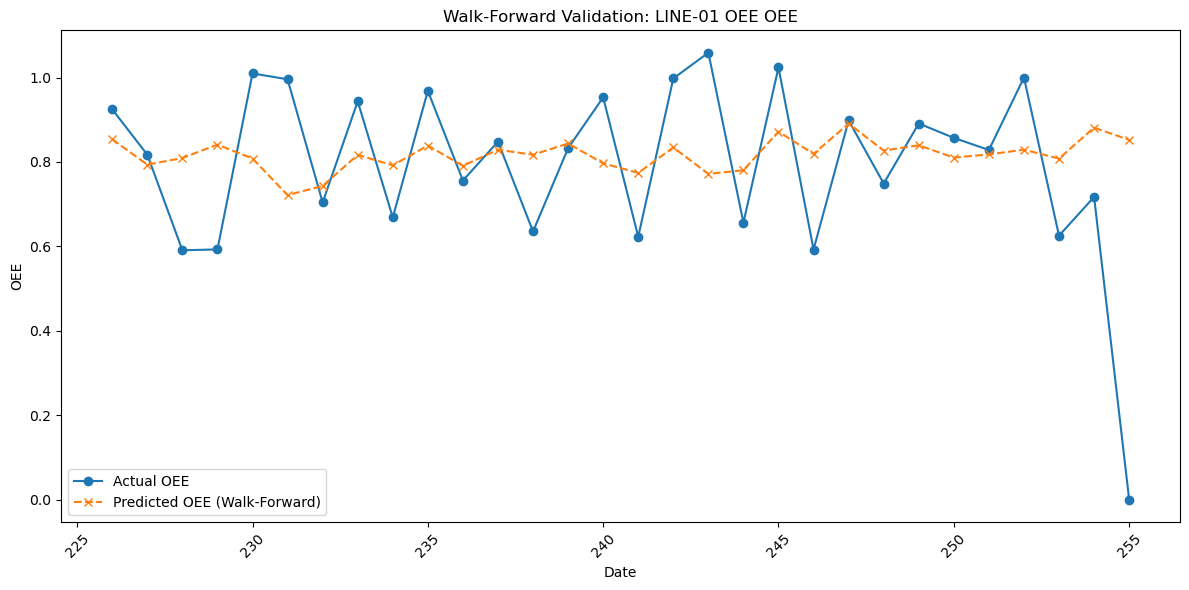

In [63]:
# --- For LINE-01 ---
# ARIMA(0,1,2)(0,0,0)[0] 
line_to_analyze = 'LINE-01'
if line_to_analyze in per_line_dataframes:
    df_selected_line = per_line_dataframes[line_to_analyze]
    if 'OEE' in df_selected_line.columns:
        oee_data_line01_original = df_selected_line['OEE'].dropna()
        # **REPLACE WITH ACTUAL ORDERS FROM YOUR auto_arima RUN FOR LINE-01**
        # This is just a placeholder. Check your auto_arima output.
        # If model_line01 was your fitted pmdarima object:
        # model_line01_params = {'order': model_line01.order, 'seasonal_order': model_line01.seasonal_order}
        model_line01_params = {'order': (0,1,2), 'seasonal_order': (0,0,0,0)} # Placeholder!
        if oee_data_line01_original.index.is_monotonic_increasing:
             actual_l01, pred_l01, mae_l01, rmse_l01 = walk_forward_validation(
                f"{line_to_analyze} OEE",
                oee_data_line01_original,
                model_line01_params,
                N_TEST_PERIODS
            )
        else:
            print(f"Data for {line_to_analyze} is not sorted by date. Please sort before validation.")
    else:
        print(f"OEE column not found for {line_to_analyze}")
else:
    print(f"Data for {line_to_analyze} not found in per_line_dataframes.")




--- Performing Walk-Forward Validation for: LINE-03 OEE ---
Using model order: (1, 0, 1), seasonal_order: (0, 0, 0, 0)
LINE-03 OEE - Day 1/30: Predicted=0.862, Actual=0.894
LINE-03 OEE - Day 2/30: Predicted=0.869, Actual=0.677
LINE-03 OEE - Day 3/30: Predicted=0.847, Actual=0.803
LINE-03 OEE - Day 4/30: Predicted=0.849, Actual=0.859
LINE-03 OEE - Day 5/30: Predicted=0.857, Actual=0.889
LINE-03 OEE - Day 6/30: Predicted=0.864, Actual=0.905
LINE-03 OEE - Day 7/30: Predicted=0.873, Actual=0.897
LINE-03 OEE - Day 8/30: Predicted=0.876, Actual=0.910
LINE-03 OEE - Day 9/30: Predicted=0.882, Actual=0.886
LINE-03 OEE - Day 10/30: Predicted=0.882, Actual=0.892
LINE-03 OEE - Day 11/30: Predicted=0.883, Actual=0.921
LINE-03 OEE - Day 12/30: Predicted=0.888, Actual=0.916
LINE-03 OEE - Day 13/30: Predicted=0.890, Actual=0.924
LINE-03 OEE - Day 14/30: Predicted=0.892, Actual=0.939
LINE-03 OEE - Day 15/30: Predicted=0.896, Actual=0.894
LINE-03 OEE - Day 16/30: Predicted=0.894, Actual=0.904
LINE-03 O

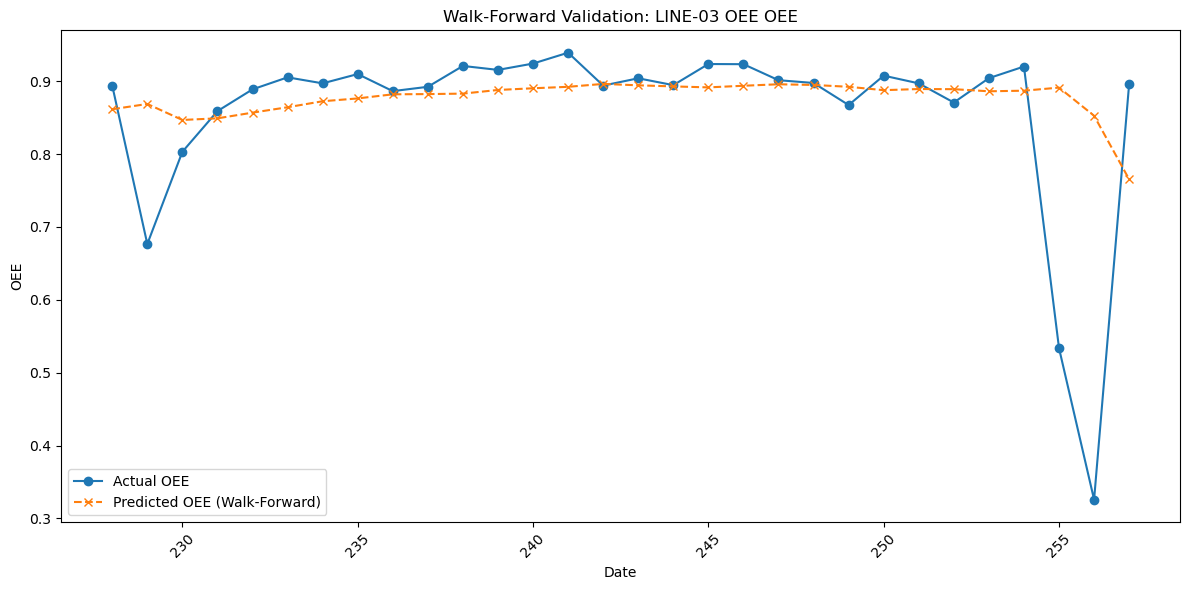

In [64]:
# --- For LINE-03 ---
# Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
line_to_analyze = 'LINE-03'
if line_to_analyze in per_line_dataframes:
    df_selected_line = per_line_dataframes[line_to_analyze]
    if 'OEE' in df_selected_line.columns:
        oee_data_line03_original = df_selected_line['OEE'].dropna()
        # **REPLACE WITH ACTUAL ORDERS FROM YOUR auto_arima RUN FOR LINE-01**
        # This is just a placeholder. Check your auto_arima output.
        # If model_line01 was your fitted pmdarima object:
        # model_line01_params = {'order': model_line01.order, 'seasonal_order': model_line01.seasonal_order}
        model_line03_params = {'order': (1,0,1), 'seasonal_order': (0,0,0,0)} # Placeholder!
        if oee_data_line03_original.index.is_monotonic_increasing:
             actual_l03, pred_l03, mae_l03, rmse_l03 = walk_forward_validation(
                f"{line_to_analyze} OEE",
                oee_data_line03_original,
                model_line03_params,
                N_TEST_PERIODS
            )
        else:
            print(f"Data for {line_to_analyze} is not sorted by date. Please sort before validation.")
    else:
        print(f"OEE column not found for {line_to_analyze}")
else:
    print(f"Data for {line_to_analyze} not found in per_line_dataframes.")


--- Performing Walk-Forward Validation for: LINE-04 OEE ---
Using model order: (2, 0, 0), seasonal_order: (0, 0, 0, 0)
LINE-04 OEE - Day 1/30: Predicted=0.875, Actual=0.915
LINE-04 OEE - Day 2/30: Predicted=0.888, Actual=0.975
LINE-04 OEE - Day 3/30: Predicted=0.905, Actual=0.937
LINE-04 OEE - Day 4/30: Predicted=0.905, Actual=0.952
LINE-04 OEE - Day 5/30: Predicted=0.904, Actual=0.948
LINE-04 OEE - Day 6/30: Predicted=0.906, Actual=0.783
LINE-04 OEE - Day 7/30: Predicted=0.871, Actual=0.785
LINE-04 OEE - Day 8/30: Predicted=0.850, Actual=0.722
LINE-04 OEE - Day 9/30: Predicted=0.835, Actual=0.798
LINE-04 OEE - Day 10/30: Predicted=0.842, Actual=0.851
LINE-04 OEE - Day 11/30: Predicted=0.864, Actual=0.906
LINE-04 OEE - Day 12/30: Predicted=0.883, Actual=0.857
LINE-04 OEE - Day 13/30: Predicted=0.879, Actual=0.861
LINE-04 OEE - Day 14/30: Predicted=0.874, Actual=0.821
LINE-04 OEE - Day 15/30: Predicted=0.865, Actual=0.913
LINE-04 OEE - Day 16/30: Predicted=0.880, Actual=0.836
LINE-04 O

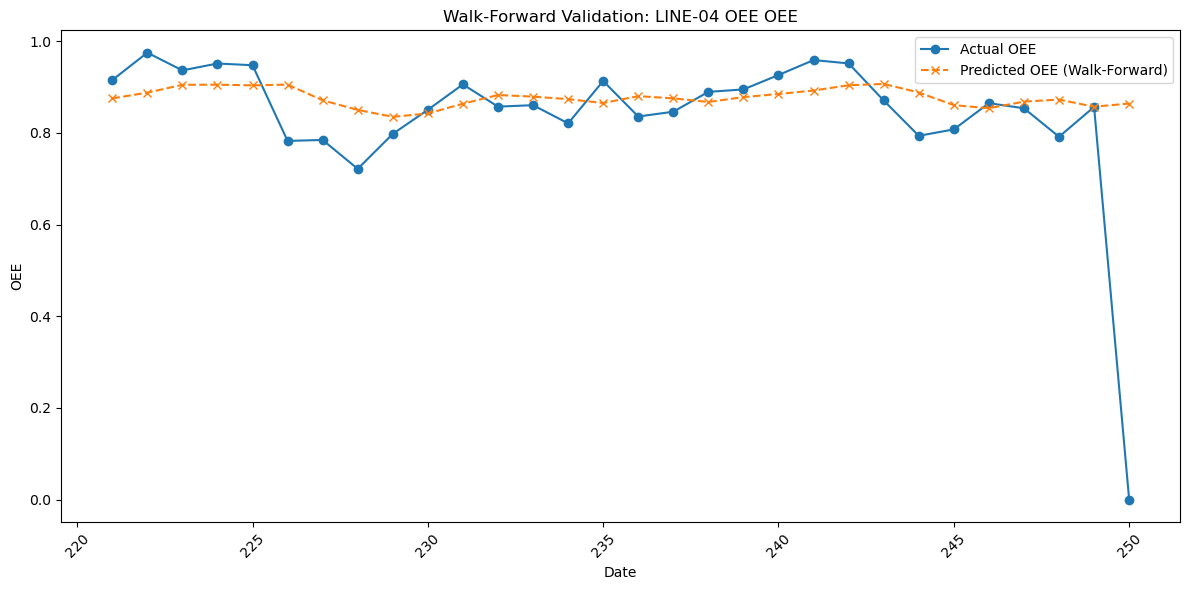

In [65]:
# --- For LINE-04 ---
#Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
line_to_analyze = 'LINE-04'
if line_to_analyze in per_line_dataframes:
    df_selected_line = per_line_dataframes[line_to_analyze]
    if 'OEE' in df_selected_line.columns:
        oee_data_line04_original = df_selected_line['OEE'].dropna()
        # **REPLACE WITH ACTUAL ORDERS FROM YOUR auto_arima RUN FOR LINE-01**
        # This is just a placeholder. Check your auto_arima output.
        # If model_line01 was your fitted pmdarima object:
        # model_line01_params = {'order': model_line01.order, 'seasonal_order': model_line01.seasonal_order}
        model_line04_params = {'order': (2,0,0), 'seasonal_order': (0,0,0,0)} # Placeholder!
        if oee_data_line04_original.index.is_monotonic_increasing:
             actual_l04, pred_l04, mae_l04, rmse_l04 = walk_forward_validation(
                f"{line_to_analyze} OEE",
                oee_data_line04_original,
                model_line04_params,
                N_TEST_PERIODS
            )
        else:
            print(f"Data for {line_to_analyze} is not sorted by date. Please sort before validation.")
    else:
        print(f"OEE column not found for {line_to_analyze}")
else:
    print(f"Data for {line_to_analyze} not found in per_line_dataframes.")




--- Performing Walk-Forward Validation for: LINE-06 OEE ---
Using model order: (1, 0, 0), seasonal_order: (0, 0, 0, 0)
LINE-06 OEE - Day 1/30: Predicted=0.883, Actual=0.914
LINE-06 OEE - Day 2/30: Predicted=0.882, Actual=0.968
LINE-06 OEE - Day 3/30: Predicted=0.899, Actual=0.884
LINE-06 OEE - Day 4/30: Predicted=0.874, Actual=0.936
LINE-06 OEE - Day 5/30: Predicted=0.889, Actual=0.804
LINE-06 OEE - Day 6/30: Predicted=0.851, Actual=0.773
LINE-06 OEE - Day 7/30: Predicted=0.842, Actual=0.827
LINE-06 OEE - Day 8/30: Predicted=0.857, Actual=0.871
LINE-06 OEE - Day 9/30: Predicted=0.870, Actual=0.837
LINE-06 OEE - Day 10/30: Predicted=0.860, Actual=0.860
LINE-06 OEE - Day 11/30: Predicted=0.867, Actual=0.960
LINE-06 OEE - Day 12/30: Predicted=0.896, Actual=0.927
LINE-06 OEE - Day 13/30: Predicted=0.887, Actual=1.052
LINE-06 OEE - Day 14/30: Predicted=0.925, Actual=0.936
LINE-06 OEE - Day 15/30: Predicted=0.890, Actual=0.920
LINE-06 OEE - Day 16/30: Predicted=0.886, Actual=0.940
LINE-06 O

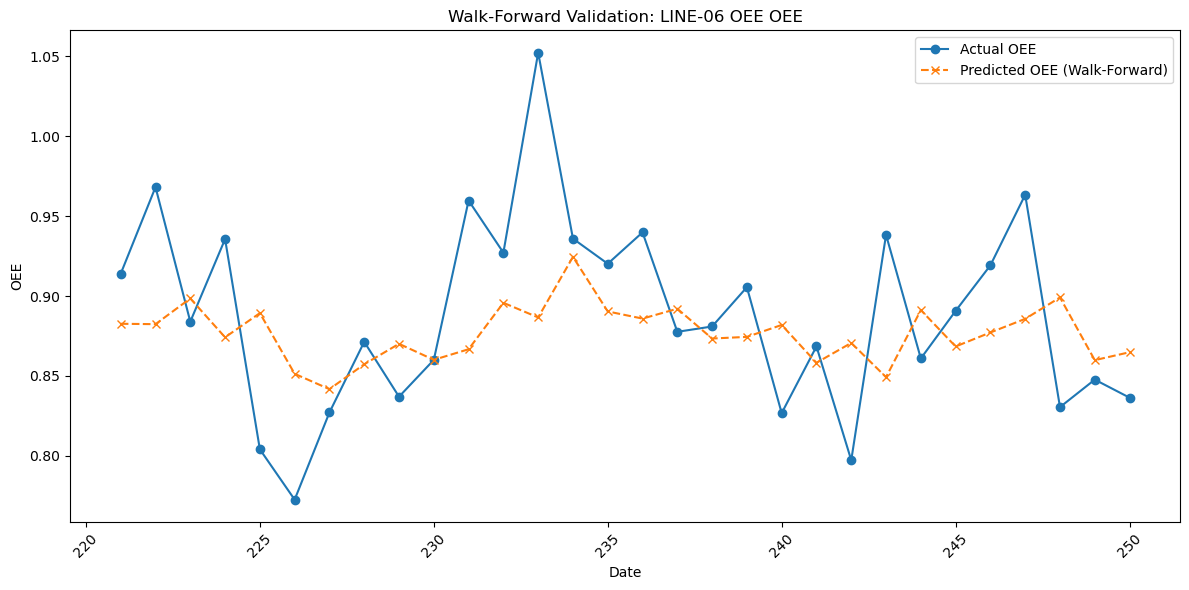

In [66]:
# --- For LINE-06 ---
# Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
line_to_analyze = 'LINE-06'
if line_to_analyze in per_line_dataframes:
    df_selected_line = per_line_dataframes[line_to_analyze]
    if 'OEE' in df_selected_line.columns:
        oee_data_line06_original = df_selected_line['OEE'].dropna()
        # **REPLACE WITH ACTUAL ORDERS FROM YOUR auto_arima RUN FOR LINE-01**
        # This is just a placeholder. Check your auto_arima output.
        # If model_line01 was your fitted pmdarima object:
        # model_line01_params = {'order': model_line01.order, 'seasonal_order': model_line01.seasonal_order}
        model_line06_params = {'order': (1,0,0), 'seasonal_order': (0,0,0,0)} # Placeholder!
        if oee_data_line06_original.index.is_monotonic_increasing:
             actual_l06, pred_l06, mae_l06, rmse_l06 = walk_forward_validation(
                f"{line_to_analyze} OEE",
                oee_data_line06_original,
                model_line06_params,
                N_TEST_PERIODS
            )
        else:
            print(f"Data for {line_to_analyze} is not sorted by date. Please sort before validation.")
    else:
        print(f"OEE column not found for {line_to_analyze}")
else:
    print(f"Data for {line_to_analyze} not found in per_line_dataframes.")




--- Performing Walk-Forward Validation for: Overall OEE ---
Using model order: (1, 0, 1), seasonal_order: (0, 0, 0, 0)
Overall OEE - Day 1/30: Predicted=1.081, Actual=1.080
Overall OEE - Day 2/30: Predicted=1.090, Actual=1.059
Overall OEE - Day 3/30: Predicted=1.087, Actual=1.033
Overall OEE - Day 4/30: Predicted=1.076, Actual=1.107
Overall OEE - Day 5/30: Predicted=1.097, Actual=1.145
Overall OEE - Day 6/30: Predicted=1.119, Actual=1.058
Overall OEE - Day 7/30: Predicted=1.101, Actual=1.143
Overall OEE - Day 8/30: Predicted=1.120, Actual=1.068
Overall OEE - Day 9/30: Predicted=1.104, Actual=1.003
Overall OEE - Day 10/30: Predicted=1.075, Actual=1.139
Overall OEE - Day 11/30: Predicted=1.106, Actual=1.095
Overall OEE - Day 12/30: Predicted=1.106, Actual=1.155
Overall OEE - Day 13/30: Predicted=1.127, Actual=1.207
Overall OEE - Day 14/30: Predicted=1.154, Actual=1.113
Overall OEE - Day 15/30: Predicted=1.136, Actual=1.180
Overall OEE - Day 16/30: Predicted=1.149, Actual=1.010
Overall O

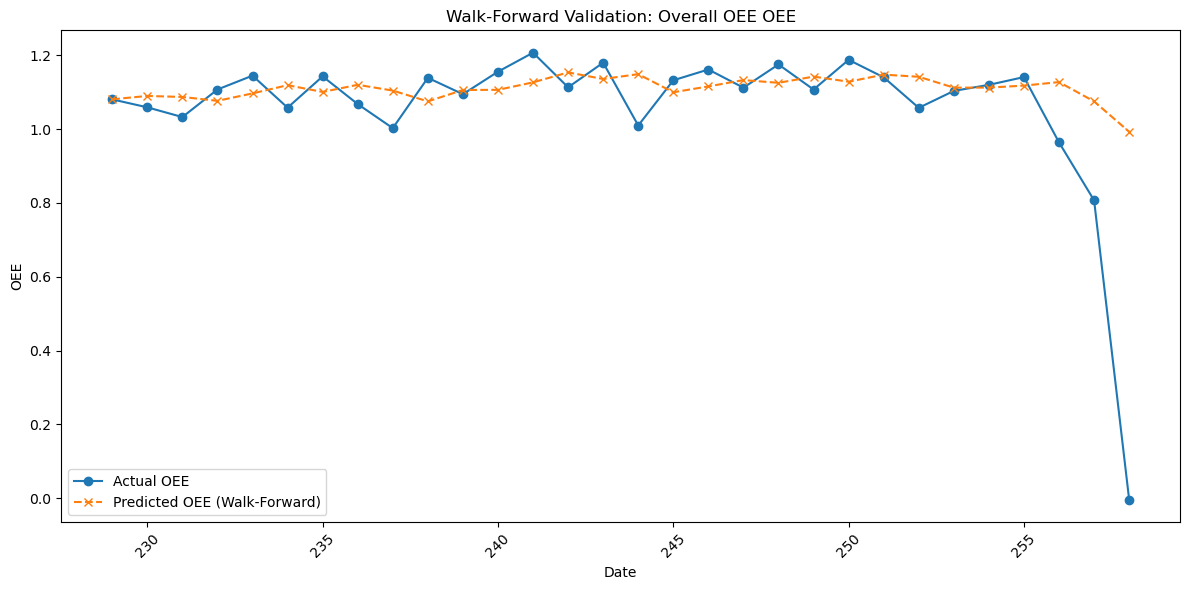

In [67]:
# --- For Overall OEE ---
# Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
if 'df_overall' in locals() and df_overall is not None and 'OEE' in df_overall.columns:
    oee_data_overall = df_overall['OEE'].dropna()
    # **REPLACE WITH ACTUAL ORDERS FROM YOUR auto_arima RUN FOR OVERALL OEE**
    # This is just a placeholder. Check your auto_arima output.
    # If model_overall_oee was your fitted pmdarima object:
    # model_overall_params = {'order': model_overall_oee.order, 'seasonal_order': model_overall_oee.seasonal_order}
    model_overall_params = {'order': (1,0,1), 'seasonal_order': (0,0,0,0)} # Placeholder!
    if oee_data_overall.index.is_monotonic_increasing:
        actual_overall, pred_overall, mae_overall, rmse_overall = walk_forward_validation(
            "Overall OEE",
            oee_data_overall,
            model_overall_params,
            N_TEST_PERIODS
        )
    else:
        print("Overall OEE data is not sorted by date. Please sort before validation.")
else:
    print("Overall OEE data ('df_overall' with 'OEE' column) not found or is empty.")

analysing results